In [ ]:
from build.code_quality_visualizer import plot_file_code_quality

plot_file_code_quality("lib/matplotlib/pyplot.py", "matplotlib", ["pylint_score", "mi"])

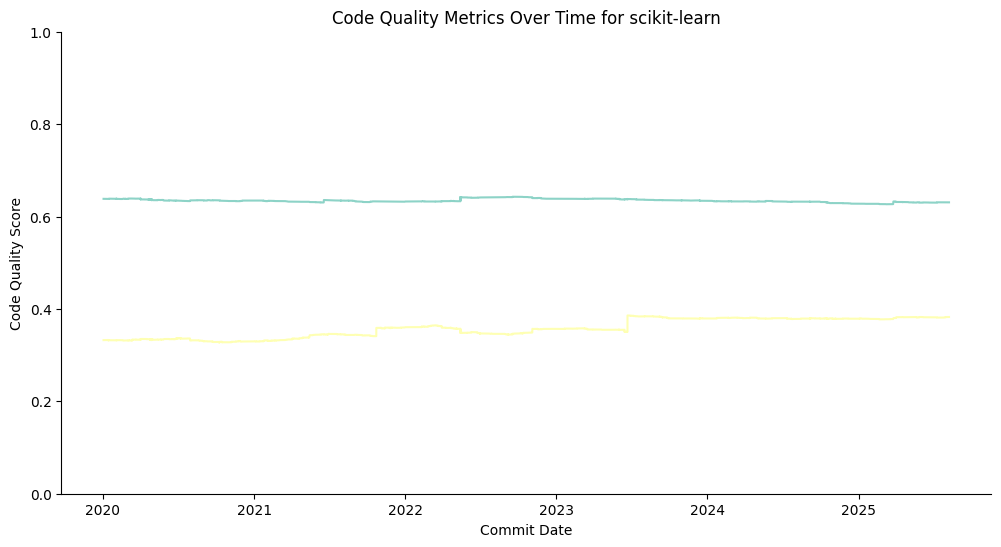

In [2]:
from build.code_quality_visualizer import plot_repo_code_quality_fast

plot_repo_code_quality_fast("scikit-learn")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


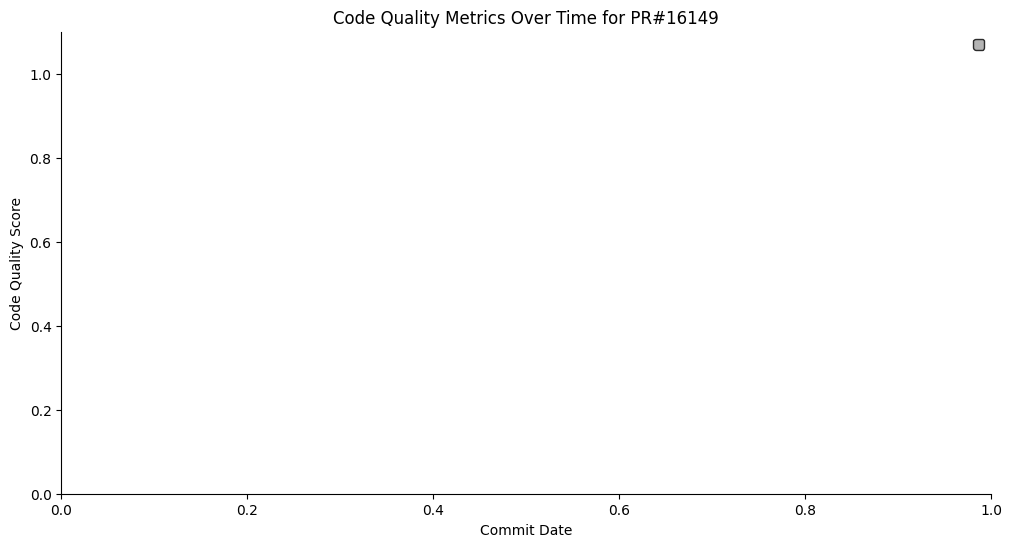

In [ ]:
# TODO Verify correctnes after log extraction

from matplotlib.colors import hex2color
from build.code_quality_analyzer import calculate_maintainability_index, get_attribute_value_at_time
from build.database_handler import get_object
from datetime import datetime
from matplotlib import pyplot as plt

def plot_pull_request_code_quality(pull_request_id, collection, metric_names=[]):
    """
    Plot the code quality metrics for a specific pull request in the repositoryd
    Args:
        pull_request_id (str): The ID of the pull request to plot the code quality metrics for
        collection (str): The name of the collection (i.e., repository) to get the metrics from.
        metric_names (list, optional): The list of metric names to include in the plot
    """
    if metric_names == []:
        print("No metric names provided, using only sloc")
        metric_names = ["sloc"]

    pull_request = get_object(pull_request_id, collection)
    if not pull_request:
        print(f"Pull request with ID {pull_request_id} not found in collection {collection}.")
        return
    metrics = {}
    input_metrics = []
    if "mi" in metric_names:
        input_metrics = (["cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"] + metric_names) # TODO Fix error where MI is in wrong order
    else: 
        input_metrics = metric_names
    default_metric_structure = {}
    for metric in input_metrics:
        default_metric_structure[metric] = None

    for relationship in pull_request["relationships"]:
        commit, file_object = None, None
        if relationship["qualifier"] == "formalises":
            commit = get_object(relationship["objectId"], collection)
        elif relationship["qualifier"] == "aggregates":
            file_object = get_object(relationship["objectId"], collection)
        if commit is not None and len(commit["attributes"]) > 0:
            commit_time = datetime.fromisoformat(commit["attributes"][0]["time"]).replace(tzinfo=None)
            metrics[commit_time] = default_metric_structure.copy()
        else:
            print(f"WARNING: Did not find related commit {relationship['objectId']} in log for PR: {pull_request_id}.")
            continue

        if file_object is not None and file_object["_id"].find(".py") != -1:
            for metric, metric_value in metrics[commit_time].items():
                if metric_value is None and metric != "mi":
                    metrics[commit_time][metric] = get_attribute_value_at_time(file_object["_id"], metric, commit_time, collection) 
                elif metric == "mi":
                    if all(metrics[commit_time][m] is not None for m in input_metrics if m != "mi"):
                        metrics[commit_time][metric] = calculate_maintainability_index(
                            metrics[commit_time]["N_1"],
                            metrics[commit_time]["N_2"],
                            metrics[commit_time]["theta_1"],
                            metrics[commit_time]["theta_2"],
                            metrics[commit_time]["cc"],
                            metrics[commit_time]["sloc"]
                        )/100
                    else: 
                        print(f"ERROR: Not all required metrics for MI calculation are available at {commit_time}.")
            # Get all files modified in all commits and then create average of metrics for files per commit
    
    plt.figure(figsize=(12, 6))
    plt.xlabel("Commit Date")
    plt.ylabel("Code Quality Score")
    plt.title(f"Code Quality Metrics Over Time for PR#{pull_request['_id']}")
    plt.ylim(0, 1.1)

    plt.legend()
    plt.show()

plot_pull_request_code_quality("16149", "scikit-learn", ["pylint_score", "mi", "cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"])

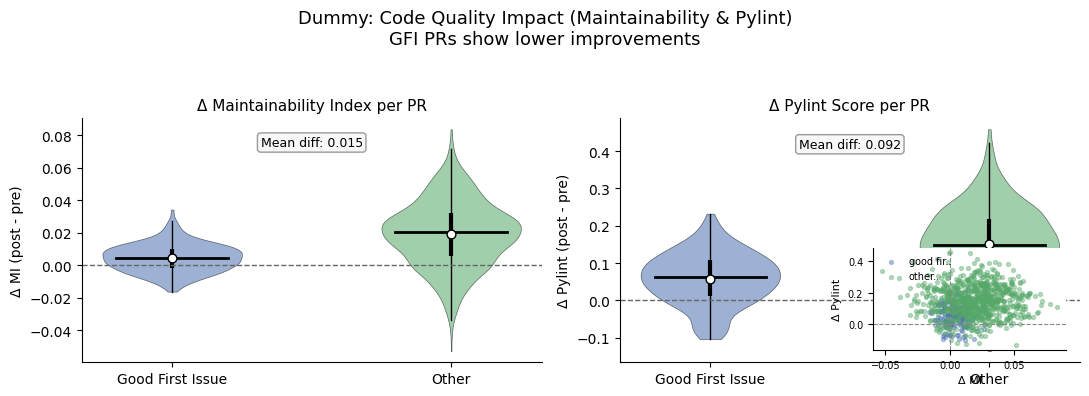

Summary:
                   count   mean_mi  median_mi    std_mi  mean_pylint  \
group                                                                 
good first issue    180  0.004432   0.004332  0.008674     0.058091   
other               800  0.019368   0.020061  0.020347     0.150367   

                  median_pylint  std_pylint  
group                                        
good first issue       0.061495    0.069592  
other                  0.147547    0.098179  
Mean difference (other - GFI) MI: 0.0149
Mean difference (other - GFI) Pylint: 0.0923


,group,delta_mi,delta_pylint
0,good first issue,0.008047,0.057173
1,good first issue,-0.005400,0.033017
2,good first issue,0.012505,-0.017061
3,good first issue,0.014406,-0.018817
4,good first issue,-0.014510,0.069349


In [10]:
# Extend dummy visualization to also include (synthetic) Pylint score deltas.

# Reuse existing rng, n_gfi, n_other, groups, etc.
# Add synthetic Pylint score improvement (delta; + => higher Pylint score after PR).
# Assumption: "other" PRs yield larger Pylint score improvements than GFI PRs.
gfi_pylint_delta = rng.normal(loc=0.05, scale=0.07, size=n_gfi)      # smaller uplift
other_pylint_delta = rng.normal(loc=0.15, scale=0.10, size=n_other)  # larger uplift
gfi_pylint_delta = np.clip(gfi_pylint_delta, -0.20, 0.40)
other_pylint_delta = np.clip(other_pylint_delta, -0.30, 0.60)

# Attach to existing dataframe (aligned order: first GFI then other, as created earlier)
df_dummy_quality["delta_pylint"] = np.concatenate([gfi_pylint_delta, other_pylint_delta])

# Recompute / extend summary
summary = df_dummy_quality.groupby("group").agg(
    count=("delta_mi","count"),
    mean_mi=("delta_mi","mean"),
    median_mi=("delta_mi","median"),
    std_mi=("delta_mi","std"),
    mean_pylint=("delta_pylint","mean"),
    median_pylint=("delta_pylint","median"),
    std_pylint=("delta_pylint","std")
)
mean_diff_mi = summary.loc["other","mean_mi"] - summary.loc["good first issue","mean_mi"]
mean_diff_pylint = summary.loc["other","mean_pylint"] - summary.loc["good first issue","mean_pylint"]

# Helper to draw a violin+box+mean for arbitrary metric
def _violin_box_mean(ax, data_arrays, colors, title, y_label, mean_diff_label=None):
    parts = ax.violinplot(data_arrays, showextrema=False, showmeans=False)
    for p, c in zip(parts["bodies"], colors):
        p.set_facecolor(c)
        p.set_alpha(0.55)
        p.set_edgecolor("black")
        p.set_linewidth(0.5)
    # Box + median + mean
    for i, arr in enumerate(data_arrays, start=1):
        q1, med, q3 = np.percentile(arr, [25,50,75])
        ax.plot([i-0.2, i+0.2], [med, med], color="black", lw=2)
        ax.plot([i, i], [q1, q3], color="black", lw=3, solid_capstyle="butt")
        iqr = q3 - q1
        lo = max(arr.min(), q1 - 1.5*iqr)
        hi = min(arr.max(), q3 + 1.5*iqr)
        ax.plot([i, i], [lo, hi], color="black", lw=1)
        ax.scatter([i], [arr.mean()], color="white", edgecolor="black", zorder=3, s=40)
    ax.set_xticks([1,2])
    ax.set_xticklabels([g.title() for g in groups])
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=11)
    ax.axhline(0, color="#666", linestyle="--", linewidth=1)
    if mean_diff_label:
        ymax = max(max(a) for a in data_arrays)
        ax.text(1.5, ymax * 0.95, mean_diff_label,
                ha="center", va="top", fontsize=9,
                bbox=dict(boxstyle="round,pad=0.25", fc="#f8f8f8", ec="#999"))

# Build combined figure (Maintainability delta + Pylint delta)
fig, axes = plt.subplots(1, 2, figsize=(11,4))

groups = ["good first issue", "other"]
colors = ["#4C72B0", "#55A868"]

# Left: Maintainability Index delta (existing metric)
mi_data = [df_dummy_quality[df_dummy_quality.group == g]["delta_mi"].values for g in groups]
_violin_box_mean(
    axes[0],
    mi_data,
    colors,
    "Δ Maintainability Index per PR",
    "Δ MI (post - pre)",
    mean_diff_label=f"Mean diff: {mean_diff_mi:.3f}"
)

# Right: Pylint score delta
pylint_data = [df_dummy_quality[df_dummy_quality.group == g]["delta_pylint"].values for g in groups]
_violin_box_mean(
    axes[1],
    pylint_data,
    colors,
    "Δ Pylint Score per PR",
    "Δ Pylint (post - pre)",
    mean_diff_label=f"Mean diff: {mean_diff_pylint:.3f}"
)

fig.suptitle("Dummy: Code Quality Impact (Maintainability & Pylint)\nGFI PRs show lower improvements", fontsize=13)
plt.tight_layout(rect=(0,0,1,0.93))

# Optional: quick scatter relation (small inset) between MI delta and Pylint delta
inset = axes[1].inset_axes([0.55, 0.05, 0.42, 0.42])
for grp, col in zip(groups, colors):
    sub = df_dummy_quality[df_dummy_quality.group == grp]
    inset.scatter(sub["delta_mi"], sub["delta_pylint"], s=8, alpha=0.4, color=col, label=grp[:8]+"..")
inset.axhline(0, ls="--", lw=0.8, color="#888")
inset.axvline(0, ls="--", lw=0.8, color="#888")
inset.set_xlabel("Δ MI", fontsize=8)
inset.set_ylabel("Δ Pylint", fontsize=8)
inset.tick_params(labelsize=7)
inset.legend(frameon=False, fontsize=7)

try:
    _set_plot_style_and_plot()
except Exception:
    plt.show()

print("Summary:\n", summary)
print(f"Mean difference (other - GFI) MI: {mean_diff_mi:.4f}")
print(f"Mean difference (other - GFI) Pylint: {mean_diff_pylint:.4f}")

# (Retain head display if desired)
df_dummy_quality.head()

In [60]:
# Start point for testing pull request related viualisations
from build.database_handler import get_pull_requests

collection = "scikit-learn"

pull_requests = get_pull_requests(collection)
ids = [pull_request["_id"] for pull_request in pull_requests]

In [61]:
# Check first action of actor in event log 
from build.database_handler import get_events

def check_first_contribution_of(user_id, collection):
    events = get_events(collection)
    for event in events:
        if _check_event_actor(event, user_id):
            if _check_is_event_contribution(event.get("type")):
                return (event.get("_id"), event.get("type"), event.get("time"), event.get("relationships"))
    return (None, None, None, None)
        

def _check_event_actor(event, user_id):
    for relationship in event.get("relationships"):
        if "by" in relationship["qualifier"] and relationship["objectId"] == user_id:
            return user_id
    else:
        return None

def _check_is_event_contribution(event_type):
    contribution_types = ["open_pull_request", "reopen_pull_request", "commit", "open_issue", "comment_pull_request", "comment_review"]
    if event_type in contribution_types:
        return True
    return False

check_first_contribution_of("Tim Head", collection)

('3114580445',
 'comment_review',
 '2025-08-13T08:45:57Z',
 [{'objectId': 'Tim Head', 'qualifier': 'commented-by'},
  {'objectId': '31909', 'qualifier': 'for-pull-request'}])

In [62]:
# Check for person last contributing to PR if it is first time contributor
from build.database_handler import get_events_for_object, get_object, get_events, get_type_of_object

def check_first_contribution_in_issue(issue_id, user_id, collection):
    first_contribution_event_id, contribution_type, contribution_time, relationships = check_first_contribution_of(user_id, collection)
    if first_contribution_event_id:
        # Get the issue object
        issue = get_object(issue_id, collection)
        if issue:
            events = get_events_for_object(issue_id, collection)
            for event in events:
                if event.get("_id") == first_contribution_event_id:
                    print(f"{user_id} first contributed to issue {issue_id} with event {contribution_type} at {contribution_time}.")
                    return True
    
    contribution = None
    if relationships:
        for relationship in relationships:
            object_type = get_type_of_object(relationship["objectId"], collection)
            if object_type == "issue" or object_type == "pull_request":
                contribution = get_object(relationship["objectId"], collection)
                if contribution:
                    print(f"{user_id}'s first contribution in {collection} was to this issue/pull_request: {contribution.get("_id")} and not in {issue_id}.")
    return False

check_first_contribution_in_issue("31865", "Tim Head", collection)

Tim Head's first contribution in scikit-learn was to this issue/pull_request: 31909 and not in 31865.


False

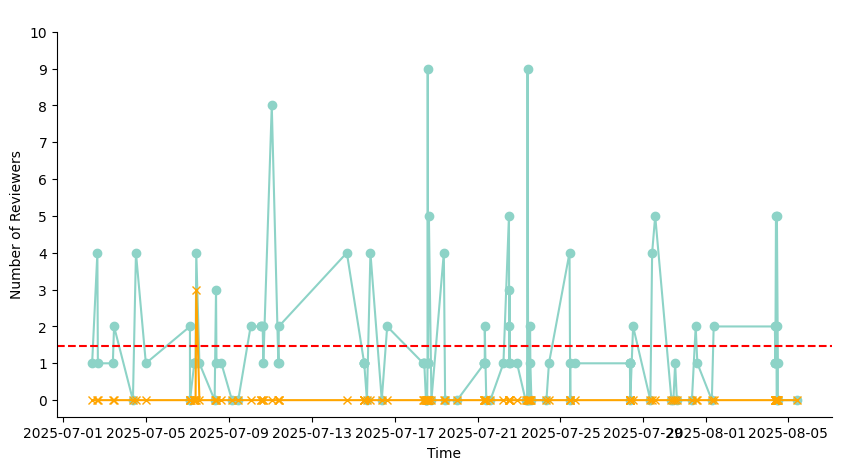

In [6]:
from build.contribution_process_analyzer import pull_request_reviewer_analysis

pull_request_reviewer_analysis(ids, collection, True)

<Figure size 1000x500 with 0 Axes>

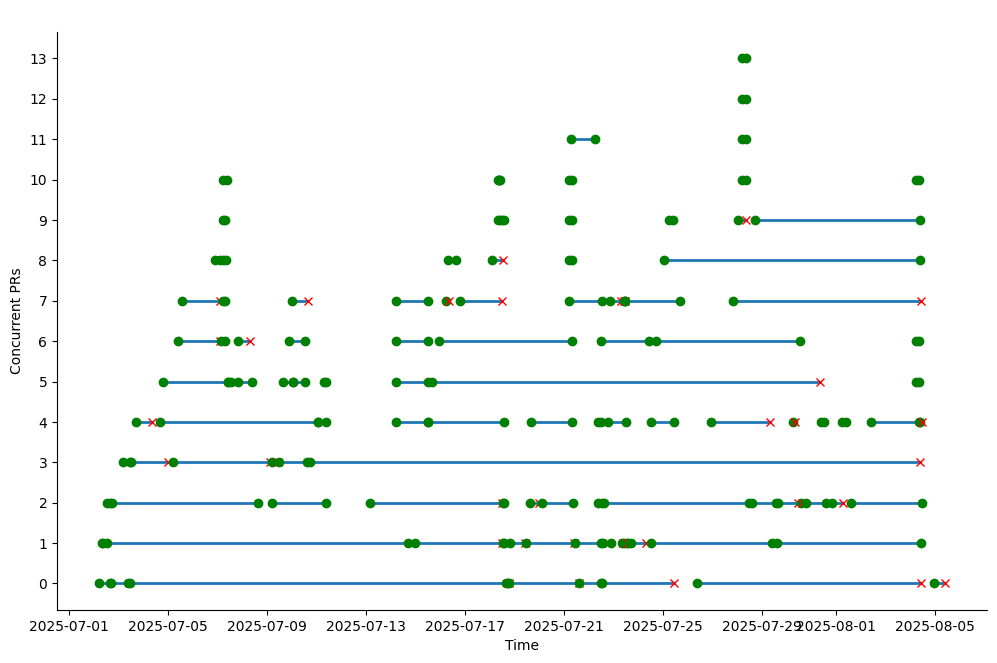

In [5]:
from build.contribution_process_analyzer import pull_request_open_time_analysis

pull_request_open_time_analysis(ids, collection, True)

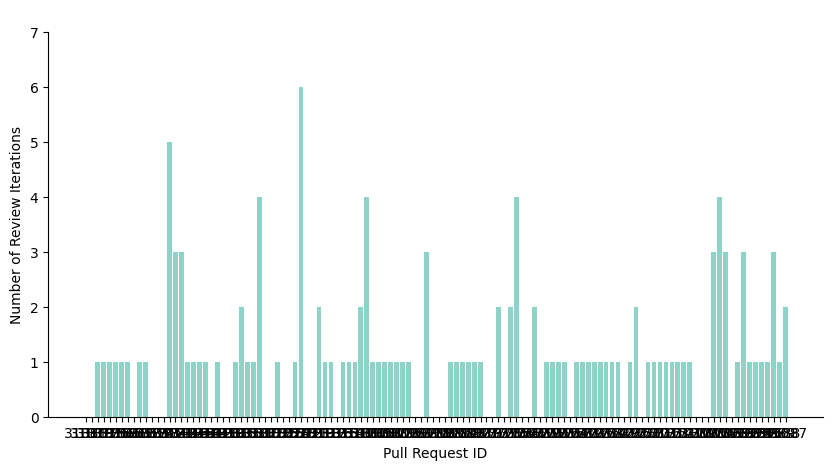

In [4]:
from build.contribution_process_analyzer import pull_request_review_iterations

pull_request_review_iterations(ids, collection, True)

/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/Bachelor-Code/build/contribution_process_analyzer.py:312: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


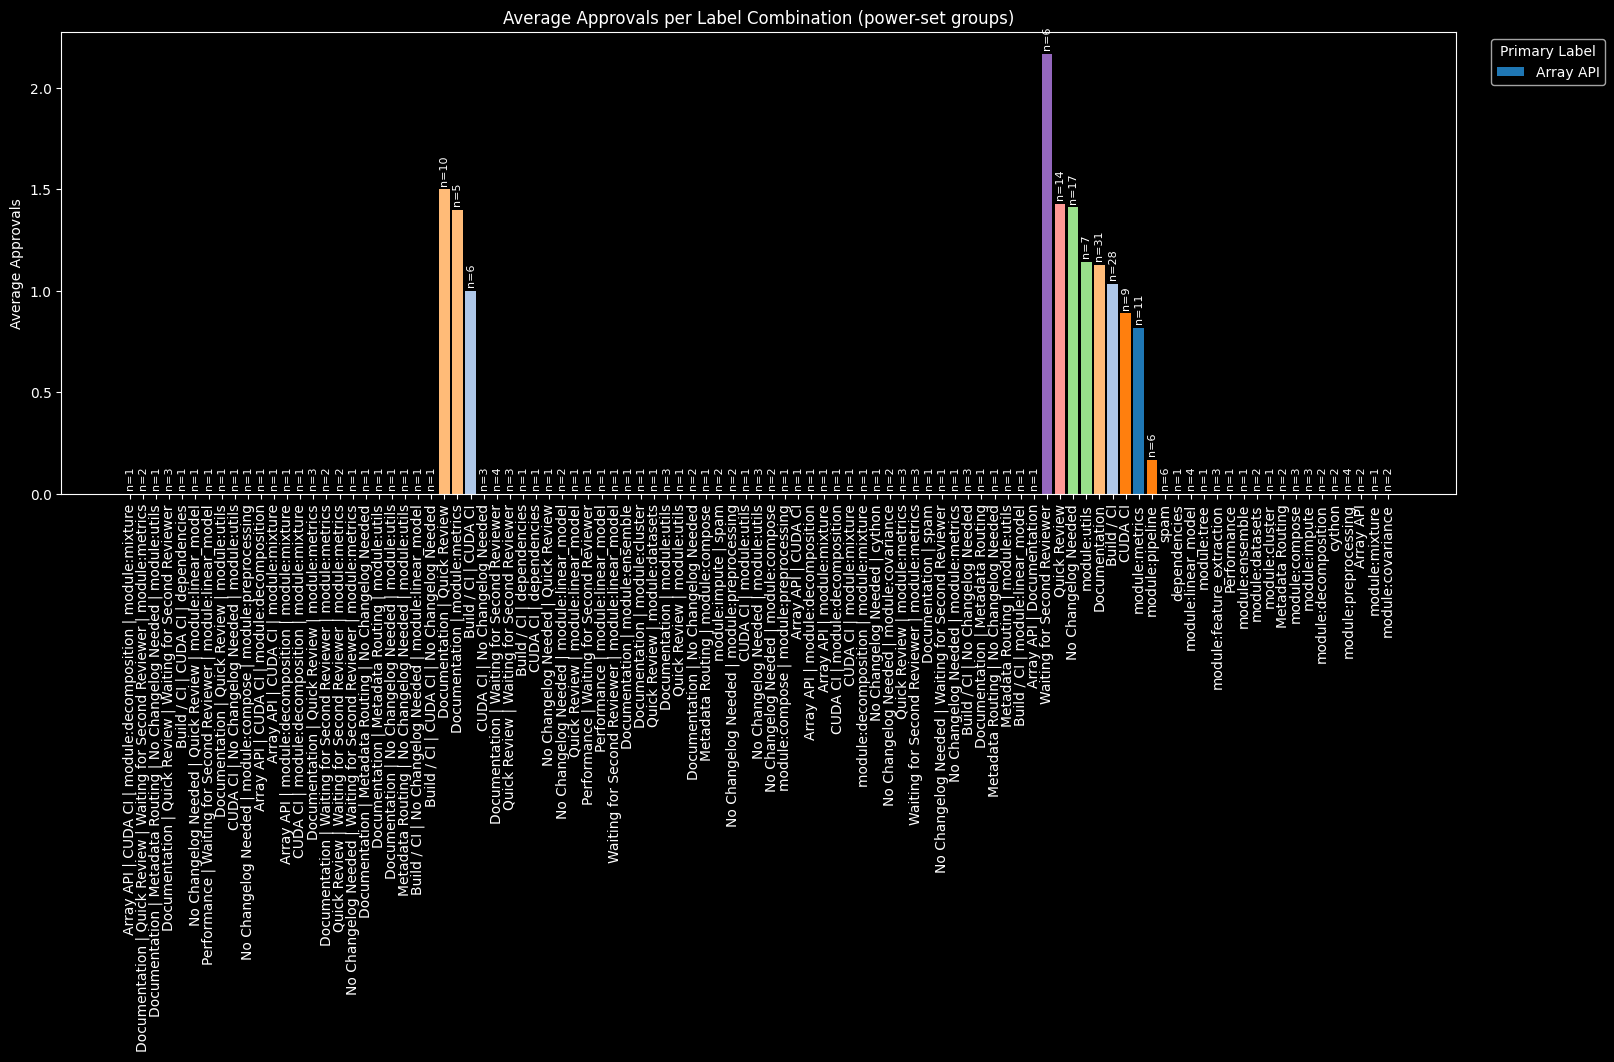

In [3]:
from build.contribution_process_analyzer import pull_request_approving_reviews, pull_request_approving_reviews_grouped
# pull_request_approving_reviews(ids, collection, True)
pull_request_approving_reviews_grouped(ids, collection, True, 5)

In [ ]:
from build.contribution_process_analyzer import pull_request_bot_ratio

pull_request_bot_ratio(ids, collection)

In [2]:
# Manually import data from other OCEL e.g. after exporting OCEL on other machine or export OCEL
import json
from build.database_handler import insert_ocel_object, insert_ocel_event
from build.database_handler import get_ocel_data

collection = "scikit-learn"

# path = f"/Users/as/Downloads/scikit-learn-local-OCEL.json"

# with open(path) as f:
#     ocel = json.load(f)

# for object in ocel["objects"]:
#     insert_ocel_object(object, collection)

# for event in ocel["events"]:
#     insert_ocel_event(event, collection)

get_ocel_data(collection)

'Exports/scikit-learn-OCEL.json'

In [64]:
from build.database_handler import get_events_for_eventType, insert_event, initialise_database
from copy import deepcopy as copy

collection = "scikit-learn"
event_type = "commit"
events = get_events_for_eventType(event_type, collection)

initialise_database(collection)

for event in events:
    insert_event(
        event["_id"],
        "commit_event",
        event["time"],
        collection,
        event["attributes"],
        event["relationships"]
    )

In [6]:
import pandas as pd
from typing import Any, Dict, List, Optional

from sympy import flatten
from build.database_handler import get_pull_requests, get_events_for_object

def _attr(obj: Dict[str, Any], name: str) -> Optional[Any]:
    for a in obj.get("attributes", []):
        if a.get("name") == name:
            return a.get("value")
    return None

def _has_good_first_issue_label(pr_obj: Dict[str, Any]) -> bool:
    val = _attr(pr_obj, "issue_label")
    if val is None:
        return False
    # Accept str, list[str], list[dict{name}]
    labels: List[str] = []
    if isinstance(val, str):
        labels = [val]
    elif isinstance(val, list):
        for x in val:
            if isinstance(x, str):
                labels.append(x)
            elif isinstance(x, dict) and "name" in x:
                labels.append(str(x["name"]))
    return any("good first issue" in s.lower() for s in labels)

def _actor_from_event(event: Dict[str, Any]) -> Optional[str]:
    for rel in event.get("relationships", []):
        # your log uses qualifiers like "authored-by", "merged-by", "commented-by"
        if "by" in rel.get("qualifier", ""):
            return rel.get("objectId")
    return None

def _flatten_event_attributes(attrs: List[Dict[str, Any]]) -> Dict[str, Any]:
    flat: Dict[str, Any] = {}
    for a in attrs or []:
        key = str(a.get("name", "")).strip().replace(" ", "_")
        if not key:
            continue
        flat[key] = a.get("value")
    return flat

from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

def flatten_ocel_to_pr_view_good_first_issue(collection: str) -> str:
    """
    Build a flat event log (one row per event) with case notion = Pull Request,
    restricted to PRs whose issue_label contains 'good first issue'.
    Columns:
      - case_id (pull request id)
      - pr_number (if available)
      - event_id, event_type, event_time, actor
      - all event attributes as separate columns
    """
    rows: List[Dict[str, Any]] = []
    pull_requests = get_pull_requests(collection) or []
    for pr in pull_requests:
        if not _has_good_first_issue_label(pr):
            continue
        pr_id = pr.get("_id")
        pr_number = _attr(pr, "number")
        events = get_events_for_object(pr_id, collection) or []
        for ev in events:
            base = {
                "case:concept:name": pr_id,
                "event_id": ev.get("_id"),
                "event_type": ev.get("type"),
                "time:timestamp": ev.get("time"),
                "actor": _actor_from_event(ev),
            }
            base.update(_flatten_event_attributes(ev.get("attributes", [])))
            rows.append(base)

    df = pd.DataFrame(rows)
    if not df.empty and "time:timestamp" in df.columns:
        # Keep original order if times are strings; convert when possible for sorting
        try:
            df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], utc=True, errors="coerce")
            df = df.sort_values(["case:concept:name", "time:timestamp", "event_id"], kind="stable")
        except Exception:
            df = df.sort_values(["case:concept:name", "event_id"], kind="stable")
    export_path = f"Exports/{collection}-pull_request-flattened.xes"
    if df is not None and rows != []:
        df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], utc=True)
        df = df.sort_values(["case:concept:name", "time:timestamp"])
        event_log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)
        xes_exporter.apply(event_log, export_path)
        return export_path

flatten_ocel_to_pr_view_good_first_issue("scikit-learn")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 1610/1610 [00:01<00:00, 1576.56it/s]


'Exports/scikit-learn-pull_request-flattened.xes'

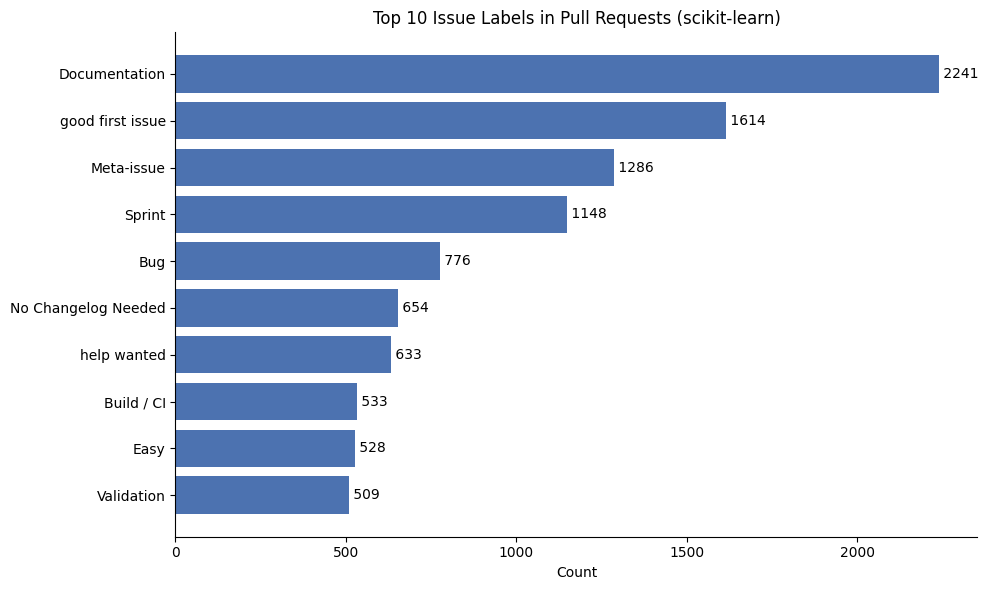

Documentation                   2241
good first issue                1614
Meta-issue                      1286
Sprint                          1148
Bug                              776
                                ... 
module:base                        1
OS:Windows                         1
hacktoberfest                      1
module:kernel_approximation        1
module:discriminant_analysis       1
Name: count, Length: 97, dtype: int64

In [21]:
from matplotlib import pyplot as plt
import pandas as pd
from typing import Any, Dict, List, Optional
from build.database_handler import get_pull_requests
from build.utils import _set_plot_style_and_plot

def _attr(obj: Dict[str, Any], name: str) -> Optional[Any]:
    for a in obj.get("attributes", []):
        if a.get("name") == name:
            return a.get("value")
    return None

def plot_pr_issue_label_distribution(collection: str, top_n: int = 10, exclude_none: bool = True, figsize=(8, 6)):
    """
    Plot distribution of the most common issue_label values in pull requests for a collection.
    Handles issue_label stored as str, comma/semicolon-separated str, list[str], or list[dict{name}].
    Returns the counts Series.
    """
    pull_requests = get_pull_requests(collection) or []
    labels = []
    for pr in pull_requests:
        val = _attr(pr, "issue_label")
        if val is None or (isinstance(val, str) and val.strip() == "") or (isinstance(val, list) and len(val) == 0):
            if not exclude_none:
                labels.append("<None>")
            continue
        if isinstance(val, str):
            # split comma/semicolon separated strings into multiple labels
            s = val.replace(";", ",")
            # Remove brackets and "'" from strings
            s = s.replace("[", "").replace("]", "").replace("'", "")
            if s == "":
                continue
            parts = [p.strip() for p in s.split(",") if p.strip()]
            labels.extend(parts if parts else [s.strip()])
        elif isinstance(val, list):
            for x in val:
                if isinstance(x, str):
                    labels.append(x.strip())
                elif isinstance(x, dict) and "name" in x:
                    labels.append(str(x["name"]).strip())

    if len(labels) == 0:
        print("No issue_label values found.")
        return pd.Series(dtype=int)

    counts = pd.Series(labels).value_counts()
    top = counts.head(top_n)[::-1]  # reverse for horizontal bar plot (largest on top)

    plt.figure(figsize=figsize)
    plt.barh(top.index, top.values, color="#4C72B0")
    plt.xlabel("Count")
    plt.title(f"Top {min(top_n, len(counts))} Issue Labels in Pull Requests ({collection})", color="black")
    for i, v in enumerate(top.values):
        plt.text(v, i, f" {v}", va="center")
    plt.tight_layout()
    _set_plot_style_and_plot()

    return counts

plot_pr_issue_label_distribution("scikit-learn", top_n=10, exclude_none=True, figsize=(10, 6))

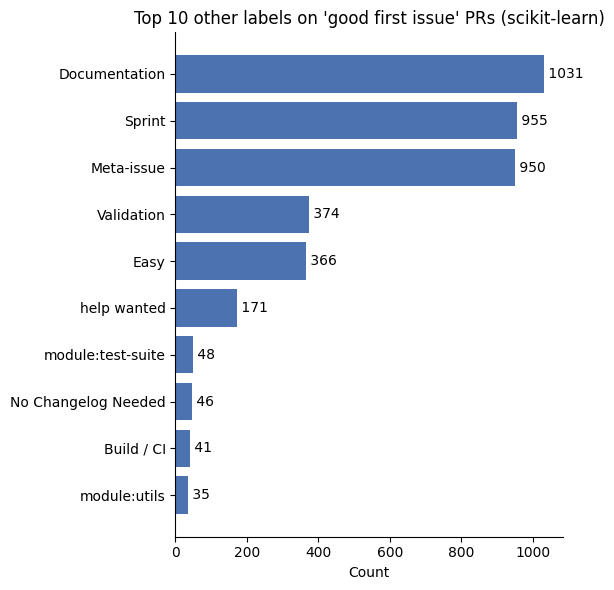

Documentation                  1031
Sprint                          955
Meta-issue                      950
Validation                      374
Easy                            366
help wanted                     171
module:test-suite                48
No Changelog Needed              46
Build / CI                       41
module:utils                     35
Enhancement                      30
Bug                              29
Moderate                         29
module:model_selection           24
module:metrics                   23
Quick Review                     22
module:cluster                   17
Waiting for Second Reviewer      17
Array API                        14
Superseded                       13
Stalled                          13
module:linear_model              12
module:datasets                  12
New Feature                      12
module:ensemble                  12
API                              10
module:naive_bayes                9
module:decomposition        

In [20]:
def gfi_other_label_distribution(collection: str, top_n: int = 20, plot: bool = True):
    """
    For PRs whose issue_label contains 'good first issue', compute distribution of
    the other labels present on those PRs. Returns a pandas Series (counts).
    """
    pull_requests = get_pull_requests(collection) or []
    counts = {}

    def _parse_labels(val):
        out = []
        if val is None:
            return out
        if isinstance(val, str):
            s = val.replace(";", ",")
            s = s.replace("[", "").replace("]", "").replace("'", "").replace('"', "")
            parts = [p.strip() for p in s.split(",") if p.strip()]
            return parts if parts else [s.strip()]
        if isinstance(val, list):
            for x in val:
                if isinstance(x, str):
                    out.append(x.strip())
                elif isinstance(x, dict) and "name" in x:
                    out.append(str(x["name"]).strip())
            return out
        return out

    for pr in pull_requests:
        try:
            if not _has_good_first_issue_label(pr):
                continue
        except Exception:
            continue
        val = _attr(pr, "issue_label")
        labels = _parse_labels(val)
        for lbl in labels:
            if lbl is None:
                continue
            if "good first issue" in str(lbl).lower():
                continue
            counts[lbl] = counts.get(lbl, 0) + 1

    if not counts:
        print(f"No other labels found on 'good first issue' PRs in collection '{collection}'.")
        return pd.Series(dtype=int)

    s = pd.Series(counts).sort_values(ascending=False)
    top = s.head(top_n)[::-1]

    if plot:
        plt.figure(figsize=(6, 6))
        plt.barh(top.index, top.values, color="#4C72B0")
        # top[::-1].plot(kind="barh", color="#4C72B0")
        plt.xlabel("Count")
        plt.title(f"Top {min(top_n, len(s))} other labels on 'good first issue' PRs ({collection})")
        for i, v in enumerate(top.values):
            plt.text(v, i, f" {int(v)}", va="center")
        plt.tight_layout()
        _set_plot_style_and_plot()

    return s

# Example usage
gfi_other_label_counts = gfi_other_label_distribution("scikit-learn", top_n=10, plot=True)
gfi_other_label_counts

In [ ]:
import random
from collections import defaultdict
import pandas as pd

# Analyze actor types (new contributor, bot, other) per activity type for a sample of PRs
def is_bot_user(actor_id: str, collection: str) -> bool:
    user = get_object(actor_id, collection)
    if not user:
        return False
    # check attributes list for is_bot-like flag
    for a in user.get("attributes", []) or []:
        name = str(a.get("name", "")).lower()
        if name == "is-bot" and bool(a.get("value")):
            return True
    return False



def analyze_pr_actor_activity(collection: str, n_prs: int = 1000, seed: int = 42, random_state: int = None):
    """
    Sample n_prs random pull requests from the collection and produce a stacked bar plot
    of activity counts per event type, split into:
      - 'new'  : actor whose first contribution event in the whole log is within that PR
      - 'bot'  : actor marked as bot (is_bot attribute present and true)
      - 'other': remaining human contributors
    Returns the counts DataFrame.
    """
    prs = get_pull_requests(collection) or []
    if not prs:
        print(f"No pull requests found for collection {collection}.")
        return None

    pr_ids = [pr["_id"] for pr in prs]
    sample_size = min(n_prs, len(pr_ids))
    random.seed(seed if random_state is None else random_state)
    sampled = random.sample(pr_ids, sample_size)

    # nested dict: event_type -> category -> count
    counts = defaultdict(lambda: defaultdict(int))

    for pr_id in sampled:
        events = get_events_for_object(pr_id, collection) or []
        pr_event_ids = {ev.get("_id") for ev in events if ev.get("_id")}

        for ev in events:
            ev_type = ev.get("type", "unknown")
            actor = _actor_from_event(ev)
            if not actor:
                continue

            # bot detection
            if is_bot_user(actor, collection):
                cat = "bot"
            else:
                # check if actor's first contribution event is one of this PR's events
                first_event_id, _, _, _ = check_first_contribution_of(actor, collection)
                if first_event_id and first_event_id in pr_event_ids:
                    cat = "new"
                else:
                    cat = "other"

            counts[ev_type][cat] += 1

    # Convert to DataFrame for plotting
    df = pd.DataFrame.from_dict({k: dict(v) for k, v in counts.items()}, orient="index").fillna(0).astype(int)
    # ensure columns order
    for col in ("new", "bot", "other"):
        if col not in df.columns:
            df[col] = 0
    df = df[["new", "bot", "other"]]

    # Plot stacked bar chart
    plt.figure(figsize=(12, 6))
    bottoms = df["new"].copy()
    p1 = plt.bar(df.index, df["new"], label="new contributors", color="#4C72B0")
    p2 = plt.bar(df.index, df["bot"], bottom=bottoms, label="bots", color="#DD8452")
    bottoms = bottoms + df["bot"]
    p3 = plt.bar(df.index, df["other"], bottom=bottoms, label="other contributors", color="#55A868")

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of activities")
    plt.xlabel("Event type")
    plt.title(f"Activity counts by actor type across {sample_size} random PRs in '{collection}'")
    plt.legend()
    plt.tight_layout()

    # annotate total on top of each bar
    totals = df.sum(axis=1)
    for i, (etype, total) in enumerate(totals.items()):
        plt.text(i, total + max(1, total * 0.01), str(total), ha="center", va="bottom", fontsize=8)

    plt.show()
    return df

# Run for 1000 random PRs from scikit-learn
counts_df = analyze_pr_actor_activity("scikit-learn", n_prs=1000, seed=42)
counts_df

NameError: name 'Dict' is not defined

Summary statistics by group:
                 n_commits                                                \
                     count      mean       std  min  25%  50%  75%   max   
group                                                                      
good first issue     826.0  5.433414  6.042159  0.0  2.0  3.0  7.0  30.0   
other               3526.0  5.923142  7.609255  0.0  1.0  3.0  7.0  30.0   

                 n_files                                                
                   count      mean       std  min  25%  50%  75%   max  
group                                                                   
good first issue   826.0  2.284504  2.690531  0.0  1.0  2.0  2.0  30.0  
other             3526.0  3.466818  5.305092  0.0  1.0  1.0  3.0  30.0  


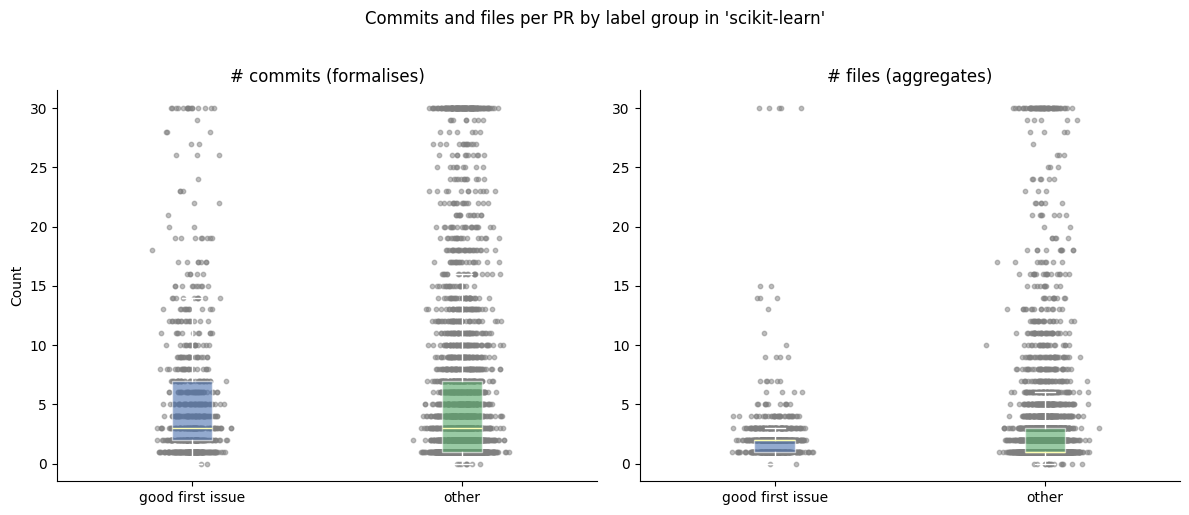

,pr_id,n_commits,n_files,group
0,23364,1,3,other
1,23362,12,4,other
2,23359,1,1,other
3,23358,4,2,other
4,23355,4,1,other
...,...,...,...,...
4347,26132,0,0,other
4348,26133,5,1,other
4349,26134,2,2,good first issue
4350,26135,2,2,good first issue


In [6]:
import numpy as np

from build.utils import _set_plot_style_and_plot

# Analyze number of commits (formalises) and files (aggregates) per PR for PRs labeled "good first issue" vs others

def pr_commits_and_files_boxplots(collection: str, figsize=(14, 6)):
    """
    Produce boxplots comparing PRs whose issue_label contains 'good first issue' vs all other PRs:
      - number of 'formalises' relationships (commits) per PR
      - number of 'aggregates' relationships (files) per PR
    Returns a DataFrame with per-PR counts and a 'group' column in {"good first issue", "other"}.
    """
    prs = get_pull_requests(collection) or []
    rows = []
    for pr in prs:
        try:
            is_gfi = _has_good_first_issue_label(pr)
        except Exception:
            # skip PRs that do not follow expected shape
            continue
        pr_id = pr.get("_id")
        rels = pr.get("relationships", []) or []
        n_commits = sum(1 for r in rels if r.get("qualifier") == "formalises")
        n_files = sum(1 for r in rels if r.get("qualifier") == "aggregates")
        rows.append({
            "pr_id": pr_id,
            "n_commits": n_commits,
            "n_files": n_files,
            "group": "good first issue" if is_gfi else "other",
        })

    if not rows:
        print(f"No pull requests found in collection '{collection}'.")
        return None

    df = pd.DataFrame(rows)

    # Print simple summary
    print("Summary statistics by group:")
    print(df.groupby("group")[ ["n_commits", "n_files"] ].describe())

    # Prepare data per group
    gfi = df[df["group"] == "good first issue"]
    oth = df[df["group"] == "other"]

    # Two panels: commits and files
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

    # Panel 1: commits
    data_commits = [gfi["n_commits"].values, oth["n_commits"].values]
    labels_commits = ["good first issue", "other"]
    bp1 = axes[0].boxplot(data_commits, labels=labels_commits, patch_artist=True, showfliers=False)
    colors = ["#4C72B0", "#55A868"]
    for patch, color in zip(bp1["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    # jitter points
    rng = np.random.default_rng(42)
    for i, arr in enumerate(data_commits, start=1):
        x = np.full_like(arr, i, dtype=float) + rng.normal(0, 0.05, size=arr.shape)
        axes[0].scatter(x, arr, color="gray", alpha=0.5, s=10)
    axes[0].set_title("# commits (formalises)")
    axes[0].set_ylabel("Count")

    # Panel 2: files
    data_files = [gfi["n_files"].values, oth["n_files"].values]
    labels_files = ["good first issue", "other"]
    bp2 = axes[1].boxplot(data_files, labels=labels_files, patch_artist=True, showfliers=False)
    for patch, color in zip(bp2["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    for i, arr in enumerate(data_files, start=1):
        x = np.full_like(arr, i, dtype=float) + rng.normal(0, 0.05, size=arr.shape)
        axes[1].scatter(x, arr, color="gray", alpha=0.5, s=10)
    axes[1].set_title("# files (aggregates)")

    fig.suptitle(f"Commits and files per PR by label group in '{collection}'", y=1.02)
    plt.tight_layout()
    _set_plot_style_and_plot()

    return df

# Run for scikit-learn (change collection name as needed)
df_gfi = pr_commits_and_files_boxplots("scikit-learn", figsize=(12, 5))
df_gfi

In [5]:
from typing import Dict, List
from build.database_handler import get_pull_requests, get_events_for_object
import matplotlib.pyplot as plt
import pandas as pd


# Plot distribution of new / bot / experienced PR authors across several PR label categories.
# Relies on existing notebook variables and functions:
#   - collection (str)
#   - get_pull_requests, get_events_for_object, check_first_contribution_of
#   - is_bot_user, _actor_from_event, _attr, _has_good_first_issue_label
#   - plt, pd, np, _set_plot_style_and_plot

def _pr_author(pr_obj: Dict) -> str:
    # try relationships first
    for rel in pr_obj.get("relationships", []) or []:
        q = (rel.get("qualifier") or "").lower()
        if "by" in q:
            return rel.get("objectId")
    # fallback: use open_pull_request event actor
    evs = get_events_for_object(pr_obj.get("_id"), collection) or []
    for ev in evs:
        if ev.get("type") == "open_pull_request":
            return _actor_from_event(ev)
    return None

def _label_values(val) -> List[str]:
    out = []
    if val is None:
        return out
    if isinstance(val, str):
        s = val.replace(";", ",").replace("[", "").replace("]", "")
        s = s.replace("'", "").replace('"', "")
        parts = [p.strip() for p in s.split(",") if p.strip()]
        return parts if parts else [s.strip()]
    if isinstance(val, list):
        for x in val:
            if isinstance(x, str):
                out.append(x.strip())
            elif isinstance(x, dict) and "name" in x:
                out.append(str(x["name"]).strip())
    return out

def pr_has_label_substring(pr_obj: Dict, substr: str) -> bool:
    val = _attr(pr_obj, "issue_label")
    if val is None:
        return False
    substr = substr.lower().strip()
    for lbl in _label_values(val):
        if substr in str(lbl).lower():
            return True
    return False

# Define categories and matching predicates
categories = [
    ("All PRs", lambda pr: True),
    ("Good First Review", lambda pr: pr_has_label_substring(pr, "good first review")),
    ("Good First Issue", lambda pr: _has_good_first_issue_label(pr)),
    ("Neither GFR nor GFI", lambda pr: (not pr_has_label_substring(pr, "good first review") and not _has_good_first_issue_label(pr))),
    ("Documentation", lambda pr: pr_has_label_substring(pr, "documentation")),
]

actor_types = ["new", "bot", "experienced"]
colors = {"new": "#4C72B0", "bot": "#DD8452", "experienced": "#55A868"}

# Initialize counters
counts: Dict[str, Dict[str, int]] = {cat[0]: {t: 0 for t in actor_types} for cat in categories}

prs = get_pull_requests(collection) or []
# Precompute PR events map for faster lookups (event ids per PR)
pr_events_cache: Dict[str, set] = {}
for pr in prs:
    evs = get_events_for_object(pr.get("_id"), collection) or []
    pr_events_cache[pr.get("_id")] = {ev.get("_id") for ev in evs if ev.get("_id")}

for pr in prs:
    pr_id = pr.get("_id")
    # determine author
    author = _pr_author(pr)
    if author is None:
        # skip PRs without author info
        continue

    # classify author
    if is_bot_user(author, collection):
        a_type = "bot"
    else:
        first_event_id, _, _, _ = check_first_contribution_of(author, collection)
        # if first contribution event is within this PR -> new
        if first_event_id and first_event_id in pr_events_cache.get(pr_id, set()):
            a_type = "new"
        else:
            a_type = "experienced"

    # increment relevant categories (a PR may match multiple categories like Documentation + others)
    for cat_name, predicate in categories:
        try:
            if predicate(pr):
                counts[cat_name][a_type] += 1
        except Exception:
            # ignore predicate errors for malformed PRs
            continue

# Build DataFrame for plotting (counts and totals)
df = pd.DataFrame.from_dict({k: v for k, v in counts.items()}, orient="index").fillna(0).astype(int)
df["total"] = df[actor_types].sum(axis=1)

# Prepare horizontal stacked bars where each bar has equal width = 1 (proportions)
prop_df = df[actor_types].div(df["total"].replace({0: 1}), axis=0)  # avoid division by 0
y_pos = np.arange(len(df))
bar_height = 0.6

plt.figure(figsize=(10, max(3.5, len(df) * 0.6)))
left = np.zeros(len(df))
for t in actor_types:
    vals = prop_df[t].values
    plt.barh(y_pos, vals, left=left, height=bar_height, color=colors[t], label=t.title())
    # annotate percentage inside segment if large enough
    for i, (l, v) in enumerate(zip(left, vals)):
        if v > 0.04:  # only annotate when segment is wide enough
            pct = f"{int(round(v * 100))}%"
            plt.text(l + v / 2, i, pct, ha="center", va="center", color="white", fontsize=9)
    left += vals

# Annotate total PR counts on the right of bars
for i, tot in enumerate(df["total"].values):
    plt.text(1.02, i, f"n={tot}", va="center", fontsize=9)

plt.yticks(y_pos, df.index)
plt.xlim(0, 1.15)
plt.xlabel("Proportion of PR authors by type (each bar normalized to width=1)")
plt.title(f"Author-type distribution across PR label categories ({collection})")
plt.legend(loc="lower right")
plt.gca().invert_yaxis()  # keep top category at top

plt.tight_layout()
try:
    _set_plot_style_and_plot()
except Exception:
    plt.show()

# Display numeric table as well
display_df = df[[*actor_types, "total"]].copy()
print("Counts per category (new / bot / experienced / total):")
print(display_df)

NameError: name 'pd' is not defined

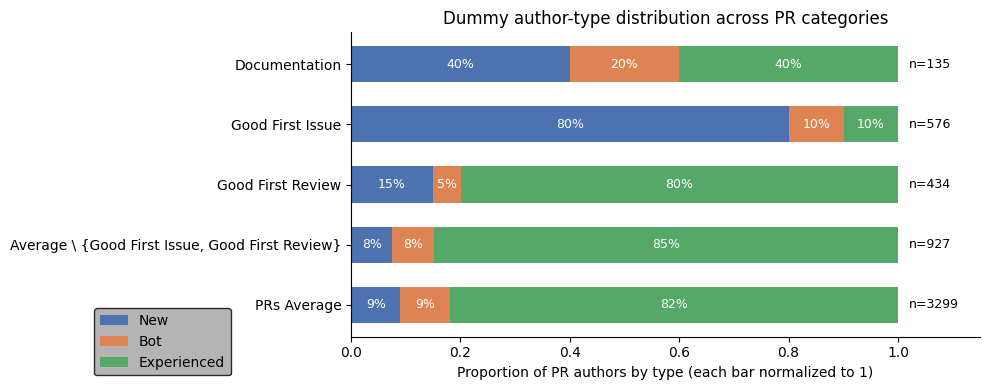

,new,bot,experienced,total
category,,,,
Documentation,54,27,54,135
Good First Issue,461,58,57,576
Good First Review,65,22,347,434
"Average \ {Good First Issue, Good First Review}",70,70,787,927
PRs Average,297,297,2705,3299


In [2]:
from build.utils import _set_plot_style_and_plot

def generate_dummy_author_distribution(seed: int = 42, plot: bool = True):
    """
    Create a dummy DataFrame with author-type distributions per category.
    Distributions (percentages):
      - Documentation: 40/20/40
      - Good First Issue: 80/10/10
      - Good First Review: 15/5/80
      - Average \\ {Good First Issue, Good First Review}: 7.5/7.5/85
      - PRs Average: 9/9/82
    Totals are randomly generated but PRs Average is enforced as largest.
    Returns pandas.DataFrame indexed by category with columns ['new','bot','experienced','total'].
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    rng = np.random.default_rng(seed)

    categories = [
        "Documentation",
        "Good First Issue",
        "Good First Review",
        r"Average \ {Good First Issue, Good First Review}",
        "PRs Average",
    ]

    # percentages as decimals (new, bot, experienced)
    percents = {
        "Documentation": (0.40, 0.20, 0.40),
        "Good First Issue": (0.80, 0.10, 0.10),
        "Good First Review": (0.15, 0.05, 0.80),
        r"Average \ {Good First Issue, Good First Review}": (0.075, 0.075, 0.85),
        "PRs Average": (0.09, 0.09, 0.82),
    }

    # sensible random totals (ranges chosen so "PRs Average" is likely largest)
    totals = {
        "Documentation": int(rng.integers(100, 501)),
        "Good First Issue": int(rng.integers(150, 701)),
        "Good First Review": int(rng.integers(120, 601)),
        r"Average \ {Good First Issue, Good First Review}": int(rng.integers(400, 1601)),
        "PRs Average": int(rng.integers(2000, 5000)),
    }

    # enforce PRs Average is >= max(other totals)
    max_other = max(t for k, t in totals.items() if k != "PRs Average")
    if totals["PRs Average"] < max_other:
        totals["PRs Average"] = max_other + int(rng.integers(10, 500))

    rows = []
    for cat in categories:
        tot = totals[cat]
        p_new, p_bot, p_exp = percents[cat]
        # compute counts, ensure integer and sum to tot (adjust experienced)
        n_new = int(round(tot * p_new))
        n_bot = int(round(tot * p_bot))
        n_exp = tot - n_new - n_bot
        # guard against negatives due to rounding
        if n_exp < 0:
            n_exp = max(0, tot - n_new - n_bot)
        rows.append({"category": cat, "new": n_new, "bot": n_bot, "experienced": n_exp, "total": tot})

    df = pd.DataFrame(rows).set_index("category")[["new", "bot", "experienced", "total"]]

    if plot:
        props = df[["new", "bot", "experienced"]].div(df["total"], axis=0)
        colors = {"new": "#4C72B0", "bot": "#DD8452", "experienced": "#55A868"}
        y = np.arange(len(df))
        height = 0.6

        plt.figure(figsize=(10, max(4, len(df) * 0.7)))
        left = np.zeros(len(df))
        for col in ["new", "bot", "experienced"]:
            vals = props[col].values
            plt.barh(y, vals, left=left, height=height, color=colors[col], label=col.title())
            # annotate percentage if wide enough
            for i, (l, v) in enumerate(zip(left, vals)):
                if v > 0.04:
                    plt.text(l + v/2, i, f"{int(round(v*100))}%", ha="center", va="center", color="white", fontsize=9)
            left += vals

        # annotate absolute totals on right
        for i, tot in enumerate(df["total"].values):
            plt.text(1.02, i, f"n={tot}", va="center", fontsize=9)

        plt.yticks(y, df.index)
        plt.xlim(0, 1.15)
        plt.xlabel("Proportion of PR authors by type (each bar normalized to 1)")
        plt.title("Dummy author-type distribution across PR categories")
        plt.legend(loc="lower right")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        # Plot legend under the figure
        plt.legend(loc="lower center", bbox_to_anchor=(-0.3, -0.15), ncol=1)
        _set_plot_style_and_plot()

    return df

generate_dummy_author_distribution()

In [22]:
# Repository-level numeric summary (robust handling of get_ocel_data and get_events)
from datetime import timedelta
import pandas as pd
import json
import os
from build.database_handler import get_events, get_object, get_pull_requests, get_events_for_object, get_ocel_data
from typing import List, Dict, Any

# Repositories to summarize
repos = ["matplotlib", "scikit-learn", "edx-platform"]


def _actor_from_event_relations(event):
    for rel in event.get("relationships", []) or []:
        qual = str(rel.get("qualifier") or "").lower()
        if "by" in qual:
            return rel.get("objectId")
    return None

summary_rows = []
for repo in repos:
    # get events (may be a pymongo cursor) -> ensure list
    try:
        events_raw = get_events(repo) or []
    except Exception:
        events_raw = []
    # convert cursor-like to list
    try:
        events = list(events_raw) if not isinstance(events_raw, list) else events_raw
    except Exception:
        events = events_raw if isinstance(events_raw, list) else []

    # get OCEL data (may be file path, dict, or None)
    try:
        ocel_raw = get_ocel_data(repo)
    except Exception:
        ocel_raw = None

    ocel = None
    n_ocel_events = 0
    n_ocel_objects = 0
    obj_types = {}

    if isinstance(ocel_raw, str):
        # assume it's a file path; check existence then read
        if os.path.exists(ocel_raw):
            try:
                with open(ocel_raw, "r", encoding="utf-8") as f:
                    ocel = json.load(f)
            except Exception:
                ocel = None
        else:
            # maybe it's JSON text
            try:
                ocel = json.loads(ocel_raw)
            except Exception:
                ocel = None
    elif isinstance(ocel_raw, dict):
        ocel = ocel_raw
    else:
        ocel = None

    if isinstance(ocel, dict):
        n_ocel_events = len(ocel.get("events", []) or [])
        n_ocel_objects = len(ocel.get("objects", []) or [])
        for o in ocel.get("objects", []) or []:
            t = o.get("type") or o.get("obj_type") or "unknown"
            obj_types[t] = obj_types.get(t, 0) + 1

    # high-level counts (fall back to 0)
    n_events_db = len(events)

    # event types, actors, times, referenced object ids, and relationship count
    event_types = set()
    actors = set()
    event_times = []
    for ev in events:
        t = ev.get("type")
        if t:
            event_types.add(t)
        a = _actor_from_event_relations(ev)
        if a:
            actors.add(a)
        tt = ev.get("time")
        if tt:
            try:
                ts = pd.to_datetime(tt, utc=True, errors="coerce")
                if not pd.isna(ts):
                    event_times.append(ts)
            except Exception:
                pass


    n_event_types = len(event_types)
    n_actors = len(actors)

    # time span (days) — numeric 0 if not available
    if event_times:
        min_time = min(event_times)
        max_time = max(event_times)
        timespan_days = (max_time - min_time).days
    else:
        min_time = None
        max_time = None
        timespan_days = 0

    # pull request / case related metrics
    try:
        prs_raw = get_pull_requests(repo) or []
    except Exception:
        prs_raw = []
    prs = list(prs_raw) if not isinstance(prs_raw, list) else prs_raw
    n_prs = len(prs)

    events_per_pr = []
    case_durations = []
    for pr in prs:
        pr_id = pr.get("_id")
        if not pr_id:
            continue
        try:
            pr_events_raw = get_events_for_object(pr_id, repo) or []
        except Exception:
            pr_events_raw = []
        pr_events = list(pr_events_raw) if not isinstance(pr_events_raw, list) else pr_events_raw
        events_per_pr.append(len(pr_events))

        # compute case duration from events times (hours)
        times = []
        for ev in pr_events:
            tt = ev.get("time")
            if tt:
                try:
                    ts = pd.to_datetime(tt, utc=True, errors="coerce")
                    if not pd.isna(ts):
                        times.append(ts)
                except Exception:
                    pass
        if times:
            dur = max(times) - min(times)
            case_durations.append(dur.total_seconds() / 3600.0)

    # numeric summaries with safe defaults
    avg_events_per_pr = float(pd.Series(events_per_pr).mean()) if events_per_pr else 0.0
    median_events_per_pr = float(pd.Series(events_per_pr).median()) if events_per_pr else 0.0
    avg_case_duration_hours = float(pd.Series(case_durations).mean()) if case_durations else 0.0
    median_case_duration_hours = float(pd.Series(case_durations).median()) if case_durations else 0.0

    # objects referenced by PR object relationships
    pr_referenced_objects = set()
    for pr in prs:
        for rel in pr.get("relationships", []) or []:
            oid = rel.get("objectId")
            if oid:
                pr_referenced_objects.add(oid)
    n_referenced_objects = len(total_referenced_objects)

    summary_rows.append({
        "repo": repo,
        "n_events_db": n_events_db,
        "n_ocel_events": n_ocel_events,
        "n_ocel_objects": n_ocel_objects,
        "n_prs (cases)": n_prs,
        "n_event_types": n_event_types,
        "n_actors": n_actors,
        "n_referenced_objects": n_referenced_objects,
        "timespan_start": pd.to_datetime(min_time).strftime("%Y-%m-%d") if min_time is not None else "",
        "timespan_end": pd.to_datetime(max_time).strftime("%Y-%m-%d") if max_time is not None else "",
        "timespan_days": timespan_days,
        "avg_events_per_pr": round(avg_events_per_pr, 2),
        "median_events_per_pr": round(median_events_per_pr, 2),
        "avg_case_duration_hours": round(avg_case_duration_hours, 2),
        "median_case_duration_hours": round(median_case_duration_hours, 2),
        "ocel_object_type_counts": obj_types,
    })

# Build DataFrame summary and display (guarantee numeric columns)
summary_df = pd.DataFrame(summary_rows).set_index("repo")
# Ensure numeric columns are numeric (fill missing with 0)
numeric_cols = ["n_events_db", "n_ocel_events", "n_ocel_objects", "n_prs (cases)",
                "n_event_types", "n_actors", "n_referenced_objects", "total_event_relationships",
                "timespan_days", "avg_events_per_pr", "median_events_per_pr",
                "avg_case_duration_hours", "median_case_duration_hours"]
for c in numeric_cols:
    if c in summary_df.columns:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").fillna(0).astype(float)

# Display only the numeric table
print("Repository-level OCEL / process-mining metrics summary (numeric):")
summary_df_display = summary_df[numeric_cols + ["timespan_start", "timespan_end", "ocel_object_type_counts"]]

Repository-level OCEL / process-mining metrics summary (numeric):


Repository-level OCEL / process-mining metrics summary (numeric):


KeyError: "['total_event_relationships'] not in index"

In [42]:
from typing import List, Set, Optional

# Cell to create a table of all events for specified PRs and their related commits.
# Uses existing notebook functions: get_object, get_events_for_object, get_events, _actor_from_event
# Returns a pandas DataFrame and displays it.

def _actor_from_event(event: Dict[str, Any]) -> Optional[str]:
    for rel in event.get("relationships", []):
        # your log uses qualifiers like "authored-by", "merged-by", "commented-by"
        if "by" in rel.get("qualifier", ""):
            return rel.get("objectId")
    return None

def pr_and_related_commit_events_table(pr_ids: List[str], collection: str):
    """
    Build and return a DataFrame containing all events related to the pull requests in pr_ids
    and any events for commit objects referenced by those PRs (qualifier == 'formalises').

    Columns: event_id, type, time, actor, source_pr, source_kind ('pull_request'|'commit'),
             related_object_ids (comma-separated), attributes (raw list)
    """
    rows = []
    seen_events: Set[str] = set()

    for pr_id in pr_ids:
        pr_obj = get_object(pr_id, collection)
        if pr_obj is None:
            print(f"Warning: PR object {pr_id} not found in collection {collection}.")
            continue

        # events directly tied to the PR object (case events)
        pr_events = get_events_for_object(pr_id, collection) or []
        for ev in pr_events:
            ev_id = ev.get("_id")
            if not ev_id or ev_id in seen_events:
                continue
            seen_events.add(ev_id)
            actor = _actor_from_event(ev) if "_actor_from_event" not in globals() else _actor_from_event(ev)
            # _actor_from_event is defined in the notebook; fallback to local if needed
            try:
                actor = _actor_from_event(ev)
            except Exception:
                actor = None
            rel_ids = ",".join([r.get("objectId", "") for r in (ev.get("relationships") or []) if r.get("objectId")])
            rows.append({
                "event_id": ev_id,
                "type": ev.get("type"),
                "time": ev.get("time"),
                "actor": actor,
                "source_pr": pr_id,
                "source_kind": "pull_request",
                "related_object_ids": rel_ids,
                "attributes": ev.get("attributes", []),
            })

        # find commit object ids referenced by the PR (qualifier 'formalises')
        commit_ids = [rel.get("objectId") for rel in (pr_obj.get("relationships") or []) if rel.get("qualifier") == "formalises" and rel.get("objectId")]
        # for each commit object, collect events that reference that commit object
        for cid in commit_ids:
            commit_events = get_events_for_object(cid, collection) or []
            for ev in commit_events:
                ev_id = ev.get("_id")
                if not ev_id or ev_id in seen_events:
                    continue
                seen_events.add(ev_id)
                try:
                    actor = _actor_from_event(ev)
                except Exception:
                    actor = None
                rel_ids = ",".join([r.get("objectId", "") for r in (ev.get("relationships") or []) if r.get("objectId")])
                rows.append({
                    "event_id": ev_id,
                    "type": ev.get("type"),
                    "time": ev.get("time"),
                    "actor": actor,
                    "source_pr": pr_id,
                    "source_kind": "commit",
                    "commit_id": cid,
                    "related_object_ids": rel_ids,
                    "attributes": ev.get("attributes", []),
                })

    if not rows:
        print("No events found for the given PR ids / related commits.")
        return None

    df = pd.DataFrame(rows)
    # normalize time and sort
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
        df = df.sort_values(["time", "event_id"]).reset_index(drop=True)

    # show a concise view first
    display_cols = ["event_id", "type", "time", "attributes", "related_object_ids"]
    display_cols = [c for c in display_cols if c in df.columns]

    return df[display_cols]

# Example usage for PRs 26971 and 26978; adjust collection as needed
df_pr_events = pr_and_related_commit_events_table(["26971", "26978"], "scikit-learn")



In [54]:
# Show a sample of the data frame (first five rows)
display(df_pr_events.head(5))

# Helper to sanitize / escape for LaTeX: remove non-ASCII (emojis), normalize whitespace, escape specials.
import re

def _latex_clean(s):
    if s is None:
        return ""
    s = str(s)
    # Flatten newlines
    s = s.replace("\n", " ").replace("\r", " ")
    # Remove all non-ASCII characters (incl. emojis)
    s = re.sub(r"[^\x00-\x7F]+", "", s)
    # Optional: collapse multiple spaces
    s = re.sub(r"\s{2,}", " ", s).strip()
    # Escape LaTeX special characters
    replacements = {
        "\\": r"\textbackslash{}",
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "#": r"\#",
        "_": r"\_",
        "{": r"\{",
        "}": r"\}",
        "~": r"\textasciitilde{}",
        "^": r"\textasciicircum{}",
    }
    return "".join(replacements.get(ch, ch) for ch in s)

# Print LaTeX table
# We set escape=False because we already escaped content manually.
print(
    df_pr_events.to_latex(
        escape=False,
        index=False,
        formatters={
            "attributes": lambda x: _latex_clean(x),
            "related_object_ids": lambda x: _latex_clean(x),
            "time": lambda x: _latex_clean(str(x).replace("+00:00", "Z").replace(" ", "T", 1)),
            "type": lambda x: _latex_clean(x),
            "event_id": lambda x: _latex_clean(x),
        },
    )
)

,event_id,type,time,attributes,related_object_ids
0,C_kwDOAAzd1toAKGNiMDEyZDVjMmU0YmVjZDEyYzlmNTMy...,commit,2023-08-01 16:22:22+00:00,[],"scaja,cb012d5c2e4becd12c9f5321950bbc29128d3e85..."
1,C_kwDOAAzd1toAKGU3NmMzNThlMDU2ZGMxOGY0MTFkZmY1...,commit,2023-08-01 18:05:31+00:00,[],"Paula Rios Lopez,e76c358e056dc18f411dff51083f9..."
2,open_pull_26971,open_pull_request,2023-08-01 18:59:13+00:00,[],"scaja,26971"
3,LE_lADOAAzd1s5tL9iVzwAAAAJS3E2d,add_label,2023-08-01 18:59:25+00:00,"[{'name': 'label', 'value': 'module:preprocess...","github-actions[bot],26971"
4,IC_kwDOAAzd1s5i_4Dq,comment_pull_request,2023-08-01 19:01:12+00:00,"[{'name': 'comment', 'value': '## ✔️ Linting P...","github-actions[bot],26971"


\begin{tabular}{lllll}
\toprule
event_id & type & time & attributes & related_object_ids \\
\midrule
C\_kwDOAAzd1toAKGNiMDEyZDVjMmU0YmVjZDEyYzlmNTMyMTk1MGJiYzI5MTI4ZDNlODU & commit & 2023-08-01T16:22:22Z & [] & scaja,cb012d5c2e4becd12c9f5321950bbc29128d3e85,26971 \\
C\_kwDOAAzd1toAKGU3NmMzNThlMDU2ZGMxOGY0MTFkZmY1MTA4M2Y5ZWRlM2M3ZGJjOTU & commit & 2023-08-01T18:05:31Z & [] & Paula Rios Lopez,e76c358e056dc18f411dff51083f9ede3c7dbc95,26978 \\
open\_pull\_26971 & open\_pull\_request & 2023-08-01T18:59:13Z & [] & scaja,26971 \\
LE\_lADOAAzd1s5tL9iVzwAAAAJS3E2d & add\_label & 2023-08-01T18:59:25Z & [\{'name': 'label', 'value': 'module:preprocessing'\}] & github-actions[bot],26971 \\
IC\_kwDOAAzd1s5i\_4Dq & comment\_pull\_request & 2023-08-01T19:01:12Z & [\{'name': 'comment', 'value': '\#\# Linting Passed\textbackslash{}nAll linting checks passed. Your pull request is in excellent shape! \textbackslash{}n\textbackslash{}n<sub> \_Generated for commit: [8678ea4](https://github.com/scikit-learn/

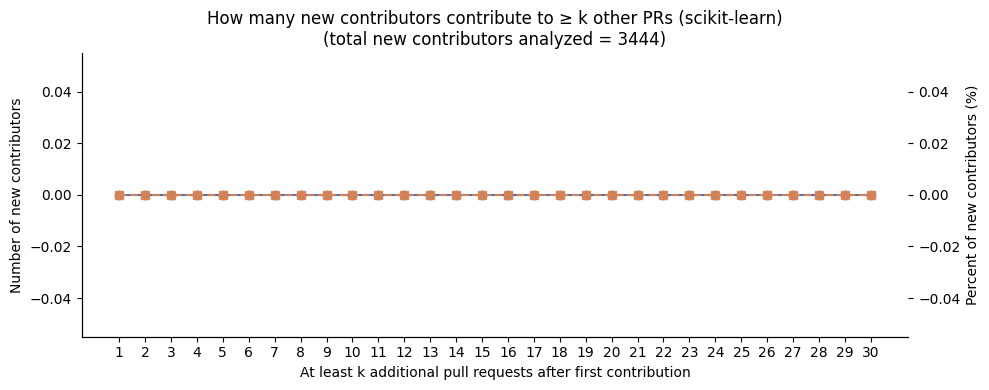

,k,count,percent
0,1,0,0.0
1,2,0,0.0
2,3,0,0.0
3,4,0,0.0
4,5,0,0.0
5,6,0,0.0
6,7,0,0.0
7,8,0,0.0
8,9,0,0.0
9,10,0,0.0


In [63]:
from typing import Dict, Set, List
import pandas as pd

# analyze_new_contributor_followups.py
# Usage: run the function plot_new_contributor_followups(...) in a notebook cell.
# Relies on existing notebook functions: get_events, get_pull_requests, get_object,
# get_type_of_object, check_first_contribution_of, and on pandas as pd and matplotlib.pyplot as plt.


def _actor_from_event_local(event: Dict) -> str:
    for rel in event.get("relationships", []) or []:
        if "by" in (rel.get("qualifier") or ""):
            return rel.get("objectId")
    return None

def plot_new_contributor_followups(collection: str, max_k: int = 20, figsize=(8, 4), show_percent: bool = True):
    """
    For actors whose first contribution is tied to a pull request, compute how many
    distinct pull requests they contributed to after that first contribution.
    Visualize the number of actors who contributed to >= k further PRs for k = 1..max_k.

    Returns a DataFrame with columns:
      - k: threshold (number of further PRs)
      - count: number of actors with >= k further PRs
      - percent: percentage of considered new contributors (if show_percent True)
    """
    # load PR ids
    prs = get_pull_requests(collection) or []
    pr_ids: Set[str] = {pr.get("_id") for pr in prs if pr.get("_id")}
    if not pr_ids:
        print(f"No pull requests found for collection '{collection}'.")
        return pd.DataFrame()

    # determine first-contribution info for all actors (uses existing helper that scans events)
    # collect actors whose first contribution is associated with some PR
    new_actors = {}  # actor_id -> (first_time (Timestamp), first_pr_id or None)
    # iterate over all actors by leveraging check_first_contribution_of (may be slower but simple)
    # we will extract actor ids from events to know which actors exist
    events_all = get_events(collection) or []
    actor_set = set()
    for ev in events_all:
        actor = _actor_from_event_local(ev)
        if actor:
            actor_set.add(actor)

    for actor in actor_set:
        first_id, first_type, first_time_str, relationships = check_first_contribution_of(actor, collection)
        if first_id is None or first_time_str is None:
            continue
        # parse time
        first_ts = pd.to_datetime(first_time_str, utc=True, errors="coerce")
        # look for a PR object referenced in relationships
        first_pr = None
        for rel in (relationships or []):
            oid = rel.get("objectId")
            if not oid:
                continue
            # quick check: if oid is in known PR ids treat it as PR
            if oid in pr_ids:
                first_pr = oid
                break
            # else try to fetch object type (may be more expensive)
            try:
                obj = get_object(oid, collection)
                if obj and (obj.get("type") == "pull_request" or obj.get("id") == oid or obj.get("_id") == oid):
                    first_pr = oid
                    break
            except Exception:
                pass
        if first_pr is not None:
            new_actors[actor] = (first_ts, first_pr)

    if not new_actors:
        print("No new contributors whose first contribution tied to a PR were found.")
        return pd.DataFrame()

    # Build map actor -> set of PR ids they contributed to after their first contribution
    actor_post_prs: Dict[str, Set[str]] = {a: set() for a in new_actors.keys()}

    # Process all events once: for events that reference PRs, record actor and PR and time
    for ev in events_all:
        ts = pd.to_datetime(ev.get("time"), utc=True, errors="coerce")
        if pd.isna(ts):
            continue
        actor = _actor_from_event_local(ev)
        if not actor or actor not in new_actors:
            continue
        # for each relationship referencing a PR id, check time > first_time and record PR id
        for rel in (ev.get("relationships") or []):
            oid = rel.get("objectId")
            if not oid:
                continue
            # quick membership check
            if oid in pr_ids:
                # ensure we count PRs that occur after the actor's first contribution time
                first_ts, _ = new_actors[actor]
                if ts > first_ts:
                    actor_post_prs[actor].add(oid)
            else:
                # attempt to check object's type if not in pr_ids (less common)
                try:
                    obj = get_object(oid, collection)
                    if obj and (obj.get("type") == "pull_request" or obj.get("type") == "PR"):
                        first_ts, _ = new_actors[actor]
                        if ts > first_ts:
                            actor_post_prs[actor].add(oid)
                except Exception:
                    continue

    # compute counts per actor
    counts = [len(s) for s in actor_post_prs.values()]
    ser = pd.Series(counts)
    total_new = len(ser)

    # prepare cumulative counts: number of actors with >= k further PRs
    rows = []
    for k in range(1, max_k + 1):
        cnt = int((ser >= k).sum())
        pct = cnt / total_new * 100.0
        rows.append({"k": k, "count": cnt, "percent": pct})

    df = pd.DataFrame(rows)

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(df["k"], df["count"], marker="o", linestyle="-", color="#4C72B0")
    plt.xlabel("At least k additional pull requests after first contribution")
    plt.ylabel("Number of new contributors")
    title = f"How many new contributors contribute to ≥ k other PRs ({collection})\n(total new contributors analyzed = {total_new})"
    plt.title(title)
    plt.xticks(range(1, max_k + 1))
    plt.grid(alpha=0.2, axis="y")

    # optionally overlay percent on secondary axis
    if show_percent:
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax2.plot(df["k"], df["percent"], marker="s", linestyle="--", color="#DD8452", alpha=0.9)
        ax2.set_ylabel("Percent of new contributors (%)")
        # annotate last point values
        for i, (x, c, p) in df.iterrows():
            if c > 0 and (x % max(1, max_k // 10) == 0 or x == 1 or x == max_k):
                ax1.text(x, c, str(c), ha="center", va="bottom", fontsize=8)
                ax2.text(x, p, f"{p:.1f}%", ha="center", va="bottom", fontsize=8, color="#DD8452")

    plt.tight_layout()
    try:
        _set_plot_style_and_plot()
    except Exception:
        plt.show()

    return df

# Example (run in the notebook):
# df_followups = plot_new_contributor_followups("scikit-learn", max_k=30, figsize=(10,4))
# df_followups.head()

plot_new_contributor_followups("scikit-learn", max_k=30, figsize=(10,4))

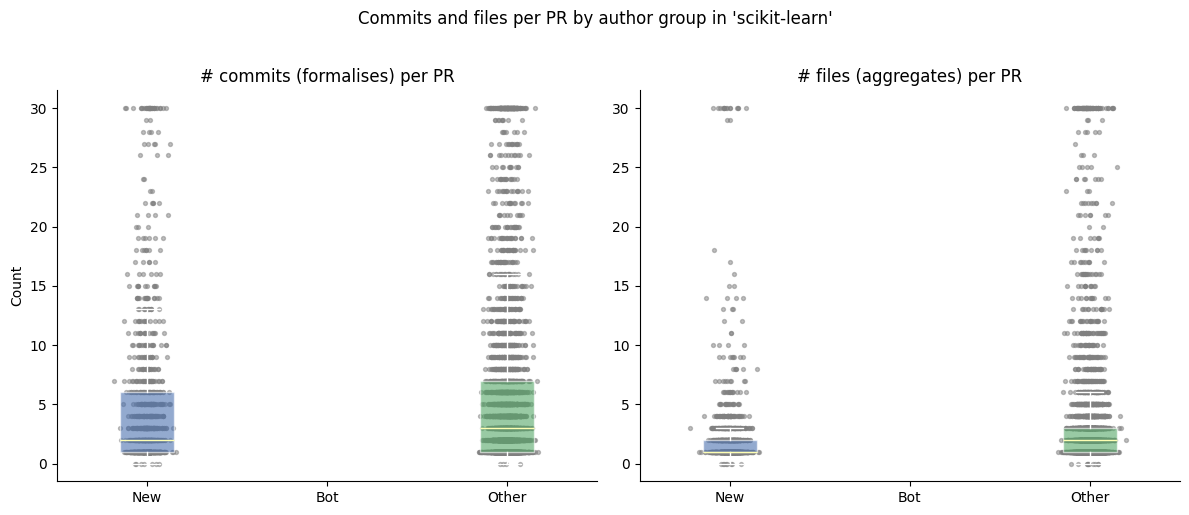

Counts per group (PRs):
group
other    3724
new      1089
Name: count, dtype: int64


,pr_id,group,n_commits,n_files
0,23364,new,1,3
1,23362,new,12,4
2,23359,new,1,1
3,23358,new,4,2
4,23355,other,4,1
...,...,...,...,...
4808,26904,other,8,3
4809,26907,other,1,1
4810,26908,new,2,1
4811,26909,other,4,10


In [11]:
def plot_pr_commits_files_by_user_group(collection: str, figsize=(14, 6), sample_limit: int = None):
    """
    For each PR in collection determine the PR author's group:
      - "new": this PR contains the author's first contribution event in the whole log
      - "bot": author detected as bot (is_bot_user)
      - "other": everyone else
    Then plot boxplots comparing number of commits (formalises) and number of files (aggregates)
    per PR across these three groups. Returns the DataFrame used for plotting.
    """
    prs = get_pull_requests(collection) or []
    if not prs:
        print(f"No pull requests found for collection '{collection}'.")
        return None

    rows = []
    # optionally limit sample for speed
    pr_list = prs if sample_limit is None else prs[:sample_limit]

    for pr in pr_list:
        pr_id = pr.get("_id")
        # try to determine PR actor from PR relationships
        actor = None
        for rel in pr.get("relationships", []) or []:
            q = rel.get("qualifier", "") or ""
            if "by" in q:
                actor = rel.get("objectId")
                break
        # fallback: find open_pull_request event actor
        if actor is None:
            events = get_events_for_object(pr_id, collection) or []
            for ev in events:
                if ev.get("type") == "open_pull_request":
                    actor = _actor_from_event(ev)
                    break

        if actor is None:
            # skip PRs without identifiable author
            continue

        # decide group
        if is_bot_user(actor, collection):
            group = "bot"
        else:
            first_event_id, _, _, _ = check_first_contribution_of(actor, collection)
            pr_event_ids = {ev.get("_id") for ev in (get_events_for_object(pr_id, collection) or []) if ev.get("_id")}
            if first_event_id and first_event_id in pr_event_ids:
                group = "new"
            else:
                group = "other"

        rels = pr.get("relationships", []) or []
        n_commits = sum(1 for r in rels if r.get("qualifier") == "formalises")
        n_files = sum(1 for r in rels if r.get("qualifier") == "aggregates")

        rows.append({"pr_id": pr_id, "group": group, "n_commits": n_commits, "n_files": n_files})

    if not rows:
        print("No PRs with actor information were found.")
        return None

    df = pd.DataFrame(rows)

    # prepare groups order and data
    groups = ["new", "bot", "other"]
    df_groups = [df[df["group"] == g] for g in groups]
    data_commits = [g["n_commits"].values for g in df_groups]
    data_files = [g["n_files"].values for g in df_groups]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

    # commits panel
    bp1 = axes[0].boxplot(data_commits, labels=[g.title() for g in groups],
                          patch_artist=True, showfliers=False)
    colors = ["#4C72B0", "#DD8452", "#55A868"]
    for patch, color in zip(bp1["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[0].set_title("# commits (formalises) per PR")
    axes[0].set_ylabel("Count")
    # overlay jitter
    rng = np.random.default_rng(42)
    for i, arr in enumerate(data_commits, start=1):
        if len(arr) > 0:
            x = np.full_like(arr, i, dtype=float) + rng.normal(0, 0.05, size=arr.shape)
            axes[0].scatter(x, arr, color="gray", alpha=0.5, s=8)

    # files panel
    bp2 = axes[1].boxplot(data_files, labels=[g.title() for g in groups],
                          patch_artist=True, showfliers=False)
    for patch, color in zip(bp2["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].set_title("# files (aggregates) per PR")
    # overlay jitter
    for i, arr in enumerate(data_files, start=1):
        if len(arr) > 0:
            x = np.full_like(arr, i, dtype=float) + rng.normal(0, 0.05, size=arr.shape)
            axes[1].scatter(x, arr, color="gray", alpha=0.5, s=8)

    fig.suptitle(f"Commits and files per PR by author group in '{collection}'", y=1.02)
    plt.tight_layout()
    try:
        _set_plot_style_and_plot()
    except Exception:
        plt.show()

    # print simple summary
    print("Counts per group (PRs):")
    print(df["group"].value_counts())

    return df

# run for scikit-learn (adjust sample_limit if you want to speed up)
df_user_groups = plot_pr_commits_files_by_user_group("scikit-learn", figsize=(12, 5), sample_limit=None)
df_user_groups

In [ ]:
# DUMMY violin plot: code quality impact (e.g., Δ Maintainability / lint score composite) by contributor type
# Assumptions (synthetic):
#   - New contributors: small improvements centered near 0.01
#   - Bots: similar small impact
#   - Other contributors: larger positive impact
rng_dummy_violin = np.random.default_rng(42)

def _trunc_norm(mean, sd, low, high, n, rng):
    x = rng.normal(mean, sd, n)
    return np.clip(x, low, high)

n_new = 200
n_bot = 160
n_other = 600

data_new = _trunc_norm(0.012, 0.010, -0.02, 0.05, n_new, rng_dummy_violin)
data_bot = _trunc_norm(0.010, 0.011, -0.02, 0.05, n_bot, rng_dummy_violin)
data_other = _trunc_norm(0.055, 0.030, -0.01, 0.15, n_other, rng_dummy_violin)

groups = ["New", "Bot", "Other"]
arrays = [data_new, data_bot, data_other]
colors = ["#4C72B0", "#DD8452", "#55A868"]

fig, ax = plt.subplots(figsize=(8, 4.5))
parts = ax.violinplot(arrays, showmeans=False, showextrema=False, showmedians=False)

for body, c in zip(parts["bodies"], colors):
    body.set_facecolor(c)
    body.set_alpha(0.6)
    body.set_edgecolor("black")
    body.set_linewidth(0.7)

# Add box & median & mean markers
for i, arr in enumerate(arrays, start=1):
    q1, med, q3 = np.percentile(arr, [25, 50, 75])
    ax.plot([i - 0.18, i + 0.18], [med, med], color="black", lw=2)
    ax.plot([i, i], [q1, q3], color="black", lw=3, solid_capstyle="butt")
    iqr = q3 - q1
    lo = max(arr.min(), q1 - 1.5 * iqr)
    hi = min(arr.max(), q3 + 1.5 * iqr)
    ax.plot([i, i], [lo, hi], color="black", lw=1)
    ax.scatter([i], [arr.mean()], color="white", edgecolor="black", zorder=3, s=40)

ax.set_xticks(range(1, len(groups) + 1))
ax.set_xticklabels(groups)
ax.set_ylabel("Δ Code Quality Metric (normalized, synthetic)")
ax.set_title("DUMMY: Code Quality Impact by Contributor Type\n(Larger improvements for 'Other' contributors)")

# Summary annotation
mean_new = data_new.mean()
mean_bot = data_bot.mean()
mean_other = data_other.mean()
ax.text(0.55, ax.get_ylim()[1] * 0.95,
        f"Means → New: {mean_new:.3f} | Bot: {mean_bot:.3f} | Other: {mean_other:.3f}",
        ha="left", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", fc="#f8f8f8", ec="#bbb"))

ax.axhline(0, ls="--", lw=1, color="#666", alpha=0.6)
plt.tight_layout()
try:
    _set_plot_style_and_plot()
except Exception:
    plt.show()

# Optional DataFrame for inspection
df_dummy_violin = pd.DataFrame({
    "group": (["new"] * n_new) + (["bot"] * n_bot) + (["other"] * n_other),
    "delta_quality": np.concatenate([data_new, data_bot, data_other])
})
df_dummy_violin.groupby("group").delta_quality.describe()

## Compilation Times (30 mins for 6800 PRs)


In [17]:
from build.database_handler import get_events, get_object
import pandas as pd
from typing import Dict, Optional, Any, List
from matplotlib import pyplot as plt



# Analyze actor types (new contributor, bot, other) per activity type for a sample of PRs
def is_bot_user(actor_id: str, collection: str) -> bool:
    user = get_object(actor_id, collection)
    if not user:
        return False
    
    if "bot" in actor_id.lower() or actor_id in ["Article", "Copilot", "Open Source Maintainers on GitHub [moved]", "Women in Machine Learning & Data Science", "azure-pipelines", "beartype", "neurodata", "scikit-learn"]:
        return True
    else:
        return False
    # check attributes list for is_bot-like flag
    for a in user.get("attributes", []) or []:
        name = str(a.get("name", "")).lower()
        if name == "is-bot" and a.get("value") == "True":
            return True
    return False


def _actor_from_event(event: Dict[str, Any]) -> Optional[str]:
    for rel in event.get("relationships", []):
        # your log uses qualifiers like "authored-by", "merged-by", "commented-by"
        if "by" in rel.get("qualifier", ""):
            return rel.get("objectId")
    return None

def _check_event_actor(event, user_id):
    for relationship in event.get("relationships"):
        if "by" in relationship["qualifier"] and relationship["objectId"] == user_id:
            return user_id
    else:
        return None

def _check_is_event_contribution(event_type):
    contribution_types = ["open_pull_request", "reopen_pull_request", "commit", "open_issue", "comment_pull_request", "comment_review"]
    if event_type in contribution_types:
        return True
    return False

def check_first_contribution_of(user_id, collection):
    events = get_events(collection)
    for event in events:
        if _check_event_actor(event, user_id):
            if _check_is_event_contribution(event.get("type")):
                return (event.get("_id"), event.get("type"), event.get("time"), event.get("relationships"))
    return (None, None, None, None)

def plot_event_type_development(collection: str,
                                event_type: str = "open_pull_request",
                                freq: str = "M",
                                figsize=(12, 5),
                                colors: dict = {},
                                show_total_line: bool = True):
    """
    Plot development over time of an event type, stacked by actor groups:
      - new    : actor's first contribution event == this event
      - bot    : actor detected as bot (is_bot_user)
      - other  : remaining actors
    The stacked area shows distribution (new + bot + other = total) per period (freq).
    Args:
      collection: repo/collection name used by database functions in the notebook
      event_type: event type to visualise (e.g., "open_pull_request")
      freq: pandas resample frequency string, e.g. 'M' (month), 'W' (week), 'D' (day)
      figsize: figure size
      colors: optional dict mapping groups to colors, keys: 'new','bot','other'
      show_total_line: if True, overlay total events as a black line
    Returns:
      pandas.DataFrame with counts per period and per group (and 'total' column).
    """
    # sensible default palette
    if colors == {}:
        colors = {"new": "#4C72B0", "bot": "#DD8452", "other": "#55A868"}

    events = get_events(collection) or []
    rows = []
    for ev in events:
        if ev.get("type") != event_type:
            continue
        t = ev.get("time")
        ts = pd.to_datetime(t, utc=True, errors="coerce")
        if pd.isna(ts):
            continue
        actor = _actor_from_event(ev)
        if not actor:
            continue

        # classify actor
        if is_bot_user(actor, collection):
            grp = "bot"
        else:
            first_event_id, _, _, _ = check_first_contribution_of(actor, collection)
            # if the actor's first contribution is exactly this event -> new
            grp = "new" if first_event_id == ev.get("_id") else "other"

        rows.append({"time": ts, "group": grp})

    if not rows:
        print(f"No events of type '{event_type}' found in collection '{collection}'.")
        return pd.DataFrame()

    df = pd.DataFrame(rows).set_index("time")

    # Aggregate counts per period and group
    counts = df.groupby([pd.Grouper(freq=freq), "group"]).size().unstack(fill_value=0)

    # ensure expected columns exist
    for c in ("new", "bot", "other"):
        if c not in counts.columns:
            counts[c] = 0
    # reorder to stable plotting order (stack bottom->top)
    counts = counts[["new", "bot", "other"]]

    # compute total
    counts["total"] = counts.sum(axis=1)

    # Prepare x values for plotting
    x = counts.index.to_timestamp() if hasattr(counts.index, "to_timestamp") else counts.index

    # Plot stacked area (stackplot expects arrays in order)
    plt.figure(figsize=figsize)
    y_new = counts["new"].values
    y_bot = counts["bot"].values
    y_other = counts["other"].values

    plt.stackplot(x,
                  y_new, y_bot, y_other,
                  labels=["new", "bot", "other"],
                  colors=[colors["new"], colors["bot"], colors["other"]],
                  alpha=0.8)

    if show_total_line:
        plt.plot(x, counts["total"].values, color="black", linewidth=1, label="total", alpha=0.9)

    plt.xlabel("Time")
    plt.ylabel("Number of events")
    plt.title(f"Development of '{event_type}' events by actor group ({collection})")
    plt.legend(loc="upper left")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    try:
        _set_plot_style_and_plot()
    except Exception:
        plt.show()

    return counts

# Example: monthly stacked development of open_pull_request events
counts = plot_event_type_development("scikit-learn", event_type="commit", freq="M", figsize=(12, 5), show_total_line=True)
counts.head()

CursorNotFound: cursor id 8373725390207152806 not found, full error: {'ok': 0.0, 'errmsg': 'cursor id 8373725390207152806 not found', 'code': 43, 'codeName': 'CursorNotFound'}

## Compilation times 20 mins for 7000 PRs

In [20]:
# ...existing code...
from datetime import timedelta
import pandas as pd
import json
from build.database_handler import get_events, get_object, get_pull_requests, get_events_for_object, get_ocel_data
from typing import List, Dict, Any

# Repositories to summarize
repos = ["matplotlib", "scikit-learn", "edx-platform"]

def _actor_from_event_relations(event):
    for rel in event.get("relationships", []) or []:
        qual = str(rel.get("qualifier") or "").lower()
        if "by" in qual:
            return rel.get("objectId")
    return None

summary_rows = []
for repo in repos:
    events = get_events(repo)
    ocel = get_ocel_data(repo)
    # high-level counts (fall back to 0)
    n_events_db = len([event for event in events])
    
    # Open ocel paths
    with open(ocel, "r", encoding="utf-8") as f:
        ocel = pd.read_json(f)
    n_ocel_events = len(ocel.get("events", [])) if isinstance(ocel.get("events", []), list) else 0
    n_ocel_objects = len(ocel.get("objects", [])) if isinstance(ocel.get("objects", []), list) else 0

    # event types, actors, times, referenced object ids, and relationship count
    event_types = set()
    actors = set()
    event_times = []
    referenced_object_ids = set()
    total_event_relationships = 0
    for ev in events:
        t = ev.get("type")
        if t:
            event_types.add(t)
        a = _actor_from_event_relations(ev)
        if a:
            actors.add(a)
        tt = ev.get("time")
        if tt:
            try:
                ts = pd.to_datetime(tt, utc=True, errors="coerce")
                if not pd.isna(ts):
                    event_times.append(ts)
            except Exception:
                pass
        for rel in ev.get("relationships", []) or []:
            oid = rel.get("objectId")
            if oid:
                referenced_object_ids.add(oid)
            total_event_relationships += 1

    n_event_types = len(event_types)
    n_actors = len(actors)

    # time span (days) — numeric 0 if not available
    if event_times:
        min_time = min(event_times)
        max_time = max(event_times)
        timespan_days = (max_time - min_time).days
    else:
        min_time = None
        max_time = None
        timespan_days = 0

    # pull request / case related metrics
    try:
        prs = get_pull_requests(repo) or []
    except Exception:
        prs = []
    n_prs = len(prs)

    events_per_pr = []
    case_durations = []
    for pr in prs:
        pr_id = pr.get("_id")
        if not pr_id:
            continue
        try:
            pr_events = get_events_for_object(pr_id, repo) or []
        except Exception:
            pr_events = []
        events_per_pr.append(len(pr_events))

        # compute case duration from events times (hours)
        times = []
        for ev in pr_events:
            tt = ev.get("time")
            if tt:
                try:
                    ts = pd.to_datetime(tt, utc=True, errors="coerce")
                    if not pd.isna(ts):
                        times.append(ts)
                except Exception:
                    pass
        if times:
            dur = max(times) - min(times)
            case_durations.append(dur.total_seconds() / 3600.0)

    # numeric summaries with safe defaults
    avg_events_per_pr = float(pd.Series(events_per_pr).mean()) if events_per_pr else 0.0
    median_events_per_pr = float(pd.Series(events_per_pr).median()) if events_per_pr else 0.0
    avg_case_duration_hours = float(pd.Series(case_durations).mean()) if case_durations else 0.0
    median_case_duration_hours = float(pd.Series(case_durations).median()) if case_durations else 0.0

    # objects referenced by PR object relationships
    pr_referenced_objects = set()
    for pr in prs:
        for rel in pr.get("relationships", []) or []:
            oid = rel.get("objectId")
            if oid:
                pr_referenced_objects.add(oid)
    total_referenced_objects = referenced_object_ids.union(pr_referenced_objects)
    n_referenced_objects = len(total_referenced_objects)

    # attempt to count object kinds if OCEL raw available
    obj_types = {}
    if isinstance(ocel.get("objects", []), list):
        for o in ocel.get("objects", []):
            t = o.get("type") or o.get("obj_type") or "unknown"
            obj_types[t] = obj_types.get(t, 0) + 1

    summary_rows.append({
        "repo": repo,
        "n_events_db": n_events_db,
        "n_ocel_events": n_ocel_events,
        "n_ocel_objects": n_ocel_objects,
        "n_prs (cases)": n_prs,
        "n_event_types": n_event_types,
        "n_actors": n_actors,
        "n_referenced_objects": n_referenced_objects,
        "total_event_relationships": total_event_relationships,
        "timespan_start": pd.to_datetime(min_time).strftime("%Y-%m-%d") if min_time is not None else "",
        "timespan_end": pd.to_datetime(max_time).strftime("%Y-%m-%d") if max_time is not None else "",
        "timespan_days": timespan_days,
        "avg_events_per_pr": round(avg_events_per_pr, 2),
        "median_events_per_pr": round(median_events_per_pr, 2),
        "avg_case_duration_hours": round(avg_case_duration_hours, 2),
        "median_case_duration_hours": round(median_case_duration_hours, 2),
        "ocel_object_type_counts": obj_types,
    })

# Build DataFrame summary and display (guarantee numeric columns)
summary_df = pd.DataFrame(summary_rows).set_index("repo")
# Ensure numeric columns are numeric (fill missing with 0)
numeric_cols = ["n_events_db", "n_ocel_events", "n_ocel_objects", "n_prs (cases)",
                "n_event_types", "n_actors", "n_referenced_objects", "total_event_relationships",
                "timespan_days", "avg_events_per_pr", "median_events_per_pr",
                "avg_case_duration_hours", "median_case_duration_hours"]
for c in numeric_cols:
    if c in summary_df.columns:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce").fillna(0).astype(float)

# Display only the numeric table
print("Repository-level OCEL / process-mining metrics summary (numeric):")
display(summary_df[numeric_cols + ["timespan_start", "timespan_end"]])
# ...existing code...

ValueError: All arrays must be of the same length

In [12]:
from build.database_handler import get_events_for_object

collection = "scikit-learn"
events = get_events_for_object("26971", collection)

for event in events:
    print(event)


{'_id': 'C_kwDOAAzd1toAKGNiMDEyZDVjMmU0YmVjZDEyYzlmNTMyMTk1MGJiYzI5MTI4ZDNlODU', 'type': 'commit_event', 'time': '2023-08-01T16:22:22Z', 'attributes': [], 'relationships': [{'objectId': 'scaja', 'qualifier': 'authored-by'}, {'objectId': 'cb012d5c2e4becd12c9f5321950bbc29128d3e85', 'qualifier': 'sha'}, {'objectId': '26971', 'qualifier': 'committed-to-pull_request'}]}
{'_id': 'LE_lADOAAzd1s5tL9iVzwAAAAJS3E2d', 'type': 'add_label', 'time': '2023-08-01T18:59:25Z', 'attributes': [{'name': 'label', 'value': 'module:preprocessing'}], 'relationships': [{'objectId': 'github-actions[bot]', 'qualifier': 'authored-by'}, {'objectId': '26971', 'qualifier': 'labeled-on-pull_request'}]}
{'_id': 'IC_kwDOAAzd1s5i_4Dq', 'type': 'comment_pull_request', 'time': '2023-08-01T19:01:12Z', 'attributes': [{'name': 'comment', 'value': '## ✔️ Linting Passed\nAll linting checks passed. Your pull request is in excellent shape! ☀️\n\n<sub> _Generated for commit: [8678ea4](https://github.com/scikit-learn/scikit-learn/p

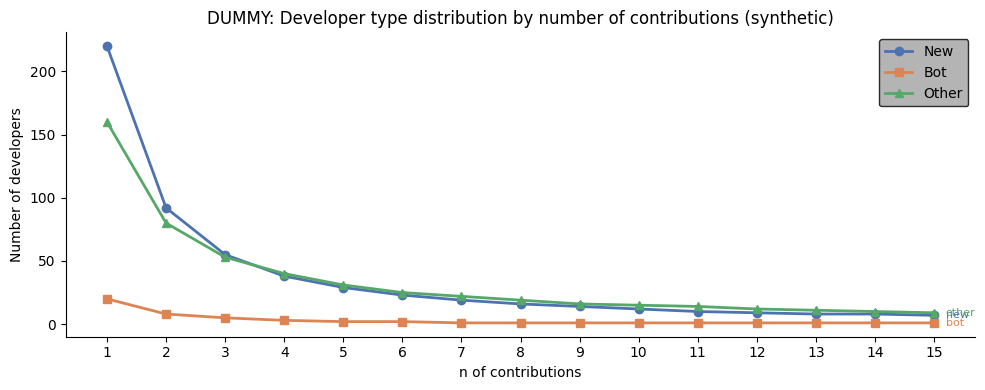

,n_contributions,new,bot,other,total
0,1,220,20,160,400
1,2,92,8,80,180
2,3,55,5,53,113
3,4,38,3,40,81
4,5,29,2,31,62
5,6,23,2,25,50
6,7,19,1,22,42
7,8,16,1,19,36
8,9,14,1,16,31
9,10,12,1,15,28


In [11]:
# DUMMY visualization: number of developers contributing n times (n=1..15)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a synthetic heavy‑tailed style distribution (dummy data)
max_n = 15
n_values = np.arange(1, max_n + 1)
# Start high then decay
developers = (400 / (n_values ** 1.2)).astype(int)
# Ensure at least 1 developer for higher n
developers = np.maximum(developers, 1)

df_dummy_contrib = pd.DataFrame({
    'n_contributions': n_values,
    'n_developers': developers
})

plt.figure(figsize=(10,4))
plt.plot(df_dummy_contrib['n_contributions'], df_dummy_contrib['n_developers'], marker='o', linewidth=2, color='#4C72B0')
plt.xticks(n_values)
plt.xlabel('n of contributions')
plt.ylabel('Number of developers')
plt.title('DUMMY: Distribution of developers by number of contributions (synthetic)')
plt.grid(alpha=0.3, linestyle=':')
# Annotate points
for x,y in zip(df_dummy_contrib['n_contributions'], df_dummy_contrib['n_developers']):
    plt.text(x, y+ (max(developers)*0.01), str(y), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
from build.utils import _set_plot_style_and_plot

_set_plot_style_and_plot()

df_dummy_contrib

In [1]:
from build.remote_repository_extractor import get_closed_pulls
from datetime import datetime

closed_pulls = get_closed_pulls("https://api.github.com/repos/scikit-learn/scikit-learn/pulls", "test-collection", start_date=datetime(2023,1,1), end_date=datetime(2023,1,31))


HTTPError: 401 Client Error: Unauthorized for url: https://api.github.com/repos/scikit-learn/scikit-learn/pulls?state=closed&per_page=100